# Imports

In [3]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import urllib.request, json
import csv
import re

#time series
import datetime
import time
from statsmodels.tsa.seasonal import seasonal_decompose
import requests

import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib.request, json
import csv
import re
import urllib.request, json
!pip install geopy
from geopy.distance import lonlat, distance, geodesic
from shapely.geometry import Point, Polygon, shape
import math
from numpy.linalg import matrix_power


plt.style.use('fivethirtyeight')
#time series
import datetime
import time
from statsmodels.tsa.seasonal import seasonal_decompose
import requests

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Datasets

## Importing the Dataset
First we import the 2 datasets (listings and listings_details)


In [5]:
#import dataset
#note change to your own directory!!! this only works on my pc 
#1 = listings   #2 = details
link = 'https://drive.google.com/open?id=1mqR7EkyLipOhmJ_kJnwpp5SRufsiXh6W'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('listings.csv')
df_1 = pd.read_csv("listings.csv")

link = 'https://drive.google.com/open?id=1P6XIk5tsm7QF1o05J24ykZsFT50eeYI6'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('listings_details.csv')
df_2 = pd.read_csv("listings_details.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (87) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
#The full datasets
# df_1.head()
# df_2.head()

## Merging the Dataset
Since both datasets have variables that are interesting for predicting the rb&b room price,
we linked the datasets together via their primary key: ID

Later we'll use dimensionality reduction since this dataset contains 111 collums which is a bit too much



In [0]:
#merging dataframe 1 and 2
merged_df = pd.merge(df_1, df_2, on="id")

## Deleting meaningless variables

Certain variables are being deleted because we think they wouldn't contribute anything meaningful
in order to predict the price. 

Some of these variables are for example:
<ol>
<li><b>Variables where over 99% had the same value<b></li>
<li><b>Text data<b>                                  </li>
<li><b>Seggregated variables<b>                           </li>
<li><b>Empty variables <b></li>
</ol>


In [0]:
#drop duplicate rows
merged_df.drop_duplicates  #if any

#rop unimportant variables
drop_cols = ["neighbourhood_group","latitude_x","longitude_x","listing_url","scrape_id","last_scraped","summary","space","description",
             "experiences_offered","neighborhood_overview","notes","transit","access","interaction","house_rules","thumbnail_url","medium_url",
            "picture_url","xl_picture_url","host_id_y","host_url","host_name_y","host_response_rate","host_acceptance_rate","host_thumbnail_url",
            "host_picture_url","host_neighbourhood","street","neighbourhood_y","neighbourhood_group_cleansed","city","state","zipcode","market",
            "smart_location","country_code","country","latitude_y","longitude_y","is_location_exact","beds","extra_people","calendar_updated",
            "has_availability","availability_30","availability_60","availability_90","calendar_last_scraped","first_review","last_review_y",
            "requires_license","license","jurisdiction_names","instant_bookable","is_business_travel_ready","require_guest_profile_picture",
            "require_guest_phone_verification","name_y"
#noticed later
            ,"name_x","host_name_x","host_about","host_total_listings_count","neighbourhood_cleansed","host_location","host_response_time"
            ,"room_type_y","price_y","minimum_nights_y","availability_365_y","number_of_reviews_y"
#latest deleted            
            ,"id","weekly_price","monthly_price","security_deposit","cleaning_fee"
            ,"square_feet","reviews_per_month_y","host_verifications","calculated_host_listings_count_y"
            ,"review_scores_accuracy","review_scores_cleanliness","review_scores_checkin","review_scores_communication","review_scores_location","review_scores_value"
            ,'host_id_x','host_is_superhost','host_listings_count','host_has_profile_pic','host_identity_verified']
            
merged_df.drop(drop_cols,axis=1,inplace=True) #inplace = true zorgt ervoor dat je meteen updated

## Polishing Variables

Currently we have all the variables, but we'll still need a bit more pre-processing to do.
Some things we thought of are:
- Splitting the dependent variable in a continous and ratio variable (this way we can use both classification models, aswell as regression models)
- Changinging certain string values to numerical values





In [0]:
#renaming the variables without x
merged_df.rename(columns={"host_id_x": "host_id","neighbourhood_x": "neighbourhood",
                          "room_type_x":"room_type","price_x":"price","minimum_nights_x":"minimum_nights","number_of_reviews_x":
                          "number_of_reviews","last_reviews_x":"last_reviews","reviews_per_month_x":"reviews_per_month",
                          "calculated_host_listings_count_x":"calculated_host_listings_count","availability_365":"availability_365",
                          "last_review_x":"last_review","availability_365_x" : "availability_365"
                           },inplace=True)

Few values with no data hence, we will assume it's 0 for other just fill in the mean. For bedrooms and bathrooms, the median is 1.

In [0]:
merged_df["last_review"] = merged_df["last_review"].fillna(value="null")
merged_df["host_since"] = merged_df["host_since"].fillna(value="null")
merged_df["bathrooms"] = merged_df["bathrooms"].fillna(value="1")
merged_df["bedrooms"] = merged_df["bedrooms"].fillna(value="1")
merged_df["reviews_per_month"] = merged_df["reviews_per_month"].fillna(merged_df["reviews_per_month"].mean())
merged_df["review_scores_rating"] = merged_df["review_scores_rating"].fillna(merged_df["review_scores_rating"].mean())

General rule, the newer the higher the number

In [0]:
def tv_internet(x):
    """
    transforms neighbourhood into 4 categories
    discretize if a house has wifi and tv or not
    """
    if  x.__contains__("TV" or "Wifi" or "internet"):
        return 1 #has internet
    else:
        return 0 # no internet

def host_since(x):
    if  x.__contains__("2007" or"2008" or "2009" or "2010" or "2011" or "2012"):      
        return "Experienced (2007-2012)"
    if  x.__contains__("2013" or "2014" or"2015"):
        return "Intermediate(2013-2016)"
    if  x.__contains__("2016" or "2017" or "2018"):
        return "Novice (2016-2018)"
    if  x.__contains__("null"):
        return "Novice (2016-2018)"
    else:
        return "Experienced (2007-2012)"


def ReviewScoreRating(x):
    return x/10

def transform_neighbourhood(x):
     if  x.__contains__("Noord"):
         return "Noord"
     if  x.__contains__("Oost"):
         return "Oost"
     if  x.__contains__("Zuid"):
         return "Zuid"
     if  x.__contains__("West"):
         return "West"
     else:
         return "Not Specified"


In [0]:
#transform neighbourhood into 1) North 2) East 3) South 4) West
merged_df["neighbourhood"] = merged_df["neighbourhood"].apply(transform_neighbourhood)

#transform host_since to 1) experienced 2) recent 3) new
merged_df["host_since"] = merged_df["host_since"].apply(host_since)

#discrteize amenities (tv or internet) yes or no
merged_df["amenities"] = merged_df["amenities"].apply(tv_internet)

#making score out of 10
merged_df["review_scores_rating"] = merged_df["review_scores_rating"].apply(ReviewScoreRating)

Changes to numeric values...

In [0]:
def CancelPolicy(x):
    if  x.__contains__("flexible"):      
        return 3
    if  x.__contains__("moderate"):
        return 2
    if  x.__contains__("strict_14_with_grace_period"):
        return 1
    if  x.__contains__("super_strict_60"):
        return 0
        
def host_since(x):
    """transforms host_since into 4 categories
        Old (2007-2012)      = 0
        Recent (2013-2016)   = 1
        new    (2017-2018)   = 2
        """
    if  x.__contains__("Experienced (2007-2012)"):      
        return 0
    if  x.__contains__("Intermediate(2013-2016)"):
        return 1
    if  x.__contains__("Novice (2016-2018)"):
        return 2

def transform_last_review(x):
    """transforms neighbourhood into 4 categories
        Old (2000-2017) = 1
        Recent (2018)   = 2
        Missing         = 3
        """
    if  x.__contains__("2005" or"2006" or "2007" or"2008" or "2009" or "2010" or "2011" 
                       "2012" or"2013" or "2014" or"2015" or "2016"):
        return 1
    if  x.__contains__("2017" or "2018"):
        return 2
    if  x.__contains__("null"):
        return 0
    else:
        return 1


In [0]:
#transform last_review to 1) old, 2) recent, 3) missing
merged_df["last_review"] = merged_df["last_review"].apply(transform_last_review)

#complete_df["price"] = complete_df["price"].apply(Price_TO_Category)
merged_df["cancellation_policy"] = merged_df["cancellation_policy"].apply(CancelPolicy)

#transform host_since to 1) experienced 2) recent 3) new
merged_df["host_since"] = merged_df["host_since"].apply(host_since)

Check if we still have any Na values.

In [15]:
merged_df.describe()

,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,host_since,accommodates,amenities,guests_included,maximum_nights,review_scores_rating,cancellation_policy
count,20030.000000,20030.000000,20030.000000,20030.000000,20030.000000,20030.000000,20030.000000,20030.000000,20030.000000,20030.000000,20030.000000,20030.000000,20030.000000,20030.000000
mean,152.181178,3.328707,21.560459,1.015926,1.062080,4.734698,59.913679,0.490714,2.891912,0.789516,1.468997,631.225711,9.484952,1.838193
std,145.828976,12.537419,43.240292,0.505890,1.250676,22.921886,104.027710,0.757006,1.318760,0.407663,0.937890,541.339981,0.619521,0.782331
min,0.000000,1.000000,0.000000,0.000000,0.010000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,2.000000,0.000000
25%,96.000000,2.000000,3.000000,1.000000,0.310000,1.000000,0.000000,0.000000,2.000000,1.000000,1.000000,21.000000,9.300000,1.000000
50%,125.000000,2.000000,8.000000,1.000000,0.740000,1.000000,3.000000,0.000000,2.000000,1.000000,1.000000,1125.000000,9.600000,2.000000
75%,175.000000,3.000000,22.000000,1.000000,1.090000,1.000000,67.000000,1.000000,4.000000,1.000000,2.000000,1125.000000,9.900000,2.000000
max,8500.000000,1001.000000,695.000000,2.000000,11.850000,208.000000,365.000000,2.000000,17.000000,1.000000,16.000000,9999.000000,10.000000,3.000000


In [16]:
merged_df.isna().values.any()

False

### Extra for Decision tree

Changes to numeric I don't agree with, hence commented

In [0]:
decision_tree = merged_df.copy()

In [0]:
def Price_TO_Category(x): #decision tree
    """
    transforms dependent variable price/day into 4 equal groups:
    1 cheap       price < €96
    2 mid-range   96  < price <= 125
    3 expensive   125 < price <= 175
    4 overpriced  price > 175
    """
    if  x <=96:
        return 1                   #cheap
    if  x > 96 and x <= 125:
         return 2                  #mid-range
    if  x > 125 and x <= 175:
         return 3                  #expensive
    if x >175:
        return 4                   #overpriced

#to numeric for k-means!
def transform_neighbourhood_numeric(x): 
    """transforms neighbourhood into 4 categories
        Noord = 1
        East  = 2
        West  = 3
        Zuid  = 4
     """
    if  x.__contains__("Noord"):
        return 1
    if  x.__contains__("Oost"):
        return 2
    if  x.__contains__("Zuid"):
        return 3
    if  x.__contains__("West"):
        return 4
    else:
        return 5

In [0]:
decision_tree["price"] = decision_tree["price"].apply(Price_TO_Category)

decision_tree["neighbourhood"] = decision_tree["neighbourhood"].apply(transform_neighbourhood_numeric)

## Final modifications

Re-arraging columns in better order

In [0]:
merged_df = merged_df[['price','neighbourhood','room_type','property_type','host_since','calculated_host_listings_count',
                       'guests_included','accommodates','bedrooms','bathrooms','bed_type','amenities','minimum_nights','maximum_nights',
                       'availability_365','cancellation_policy','number_of_reviews','review_scores_rating','last_review','reviews_per_month']]

In [0]:
complete_df = merged_df.copy()

# Data1 (not too many dummies)

Transforming the data again, from string to number in order to run programs

In [0]:
data1 = complete_df.copy()

In [0]:
def room_type(x):
    """transforms room_type home or not home
        Entire home/apt      = 1
        Other                = 0
        """
    if  x.__contains__("Entire home/apt"):      
        return 1
    else:
      return 0

def property_type(x):
    """transforms property_type into apartment or not apartment
        Apartment      = 1
        Other          = 0
        """
    if  x.__contains__("Apartment"):      
        return 1
    else:
      return 0

def bed_type(x):
    """transforms bed_type into real bed or not real bed
        Real bed      = 1
        Other         = 0
        """
    if  x.__contains__("Real Bed"):      
        return 1
    else:
      return 0


def Price_TO_Category(x): #decision tree
    """
    transforms dependent variable price/day into 4 equal groups:
    1 cheap       price < €96
    2 mid-range   96  < price <= 125
    3 expensive   125 < price <= 175
    4 overpriced  price > 175
    """
    if  x <=96:
        return "cheap"                   #cheap
    if  x > 96 and x <= 125:
         return "mid-range"                  #mid-range
    if  x > 125 and x <= 175:
         return "expensive"                  #expensive
    if x >175:
        return "very-expensive"                   #overpriced

dummiesNeigh = pd.get_dummies(data1['neighbourhood']).iloc[:,1:]

In [0]:
data1["room_type"] = data1["room_type"].apply(room_type)
data1["property_type"] = data1["property_type"].apply(property_type)
data1["bed_type"] = data1["bed_type"].apply(property_type)
data1 = pd.concat([data1, dummiesNeigh], axis=1) #this Noord as 0
data1 = data1.drop(['neighbourhood'],axis=1)
data1["price"] = data1["price"].apply(Price_TO_Category)

In [25]:
data1

,price,room_type,property_type,host_since,calculated_host_listings_count,guests_included,accommodates,bedrooms,bathrooms,bed_type,amenities,minimum_nights,maximum_nights,availability_365,cancellation_policy,number_of_reviews,review_scores_rating,last_review,reviews_per_month,Not Specified,Oost,West,Zuid
0,cheap,0,1,0,1,1,2,1,1.5,0,0,3,15,44,1,248,9.700000,1,2.10000,0,1,0,0
1,expensive,1,1,0,1,2,5,2,1,0,0,4,20,47,2,42,9.600000,1,1.03000,0,0,1,0
2,cheap,1,0,0,2,2,2,1,1,0,1,1,1000,198,1,233,8.700000,1,2.18000,0,1,0,0
3,mid-range,1,1,0,2,2,3,1,1,0,1,14,60,141,1,1,10.000000,1,0.09000,0,0,1,0
4,expensive,0,0,0,1,1,2,1,1,0,1,2,730,199,1,171,9.900000,1,2.03000,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20025,very-expensive,1,0,0,1,1,4,3,2,0,1,7,12,11,1,0,9.484952,0,1.06208,1,0,0,0
20026,expensive,1,1,0,2,1,3,2,1,0,1,3,14,16,3,0,9.484952,0,1.06208,0,1,0,0
20027,cheap,1,1,2,2,1,2,1,1,0,1,10,22,210,2,0,9.484952,0,1.06208,0,1,0,0
20028,cheap,0,1,0,2,1,2,1,1,0,1,2,15,31,3,0,9.484952,0,1.06208,0,1,0,0


## Random split train/test

This is a random split

In [0]:
X1 = data1.drop(['price'],axis=1)
y1 = data1['price']

In [0]:
from sklearn.model_selection import train_test_split

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=0)

In [0]:
# Saving feature names for later use
feature_list1 = list(X1.columns)

## Manual split train/test (commented)

This would be a selected split

In [0]:
# train_data1 = data1[:10030]
# forecast_data1 = data1[10030:]
# forecast_data1 = forecast_data1.reset_index().drop(['index'],axis=1)

In [0]:
# X_train1 = train_data1.drop(['price'],axis=1)
# y_train1 = train_data1['price']

# X_test1 = forecast_data1.drop(['price'],axis=1)
# y_test1 = forecast_data1['price']

# Data Visualization

In [0]:
merged_df = complete_df.copy()

## In this section we'll be doing 3 things 
We'll be looking at the price, the characteristics of the room and characteristics of the host.

1) Basic descriptive statistics/graphs for the price (per night)
first we're looking at these var in relation to the price

2) Characteristics of the home

Second we'll pick some variables to scout for striking features <br>
we'll check correlations/anova etc

- Neigbourhood (categorical)<br> 
- Room type (categorical)<br> 
- Number of reviews (numerical)<br> 
- Last review (ordinal) <br> 
- Calculated host listings(numerical) <br> 
- Host_since (categorical) <br>
- Property type (categorical)<br>
- Bedrooms (ordinal))<br>
- Acomodates (numerical) <br>
- Amenities (boolean)<br>
- Max Nights (numerical) <br>
- Review Score Rating (numerical) <br>
- Cancellation policy (ordinal)<br>

3) Look at the the type of hosts hosts (who are selling the house)

### 1) Price

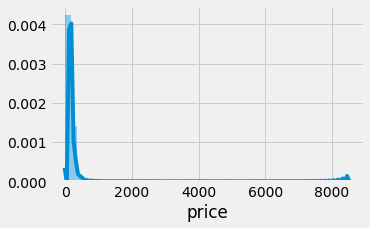

count    20030.000000
mean       152.181178
std        145.828976
min          0.000000
25%         96.000000
50%        125.000000
75%        175.000000
max       8500.000000
Name: price, dtype: float64

In [32]:
fig = plt.figure()
fig.set_size_inches(5,3)

sns.distplot(merged_df["price"])
plt.show()

merged_df["price"].describe()

#### Correlation (Numeric with price)


In [33]:
#correlation example
correlation = merged_df[["price","number_of_reviews","calculated_host_listings_count","bedrooms","accommodates","maximum_nights","review_scores_rating"]].corr().drop("price")
correlation["price"].sort_values()

#as we can see, accomodates and bedrooms have the highest correlation with price. The rest doesn't really correlate at all with price

number_of_reviews                -0.067417
maximum_nights                    0.002283
calculated_host_listings_count    0.017409
review_scores_rating              0.025585
accommodates                      0.356543
Name: price, dtype: float64

#### Annova (categoric with price)



In [34]:
#anova example

#hypothese testing: Variables significantly differ:
import statsmodels.api as sm
from statsmodels.formula.api import ols

neighbourhood = merged_df[["neighbourhood","price"]]
room_type = merged_df[["room_type","price"]]
host_since = merged_df[["host_since","price"]]
property_type = merged_df[["property_type","price"]]
bedrooms = merged_df[["bedrooms","price"]]
cancellation_policy = merged_df[["cancellation_policy","price"]]

lm1 = ols( "price ~ neighbourhood ", data= neighbourhood).fit()
lm2 = ols( "price ~room_type", data= room_type).fit()
lm4 = ols( "price ~host_since", data= host_since).fit()
lm5 = ols( "price ~ property_type ", data= property_type).fit()
lm6 = ols( "price ~ bedrooms ", data=  bedrooms).fit()
lm7 = ols( "price ~ cancellation_policy ", data= cancellation_policy).fit()

table1 = sm.stats.anova_lm(lm1)
table2 = sm.stats.anova_lm(lm2)
table4 = sm.stats.anova_lm(lm4)
table5 = sm.stats.anova_lm(lm5)
table6 = sm.stats.anova_lm(lm6)
table7 = sm.stats.anova_lm(lm7)

print("P-value for neighbourhood anova is:")
print(table1["PR(>F)"][0]) 
print("significant\n")

print("P-value for room_type anova is:")
print(table2["PR(>F)"][0])
print("significant\n")

print("P-value for host_since anova is:")
print(table4["PR(>F)"][0])
print("NOT significant\n")

print("P-value for property_type anova is:")
print(table5["PR(>F)"][0])
print("significant\n")

print("P-value for bedroomsis:")
print(table6["PR(>F)"][0])
print("significant\n")

print("P-value for cancellation_policy is:")
print(table7["PR(>F)"][0])
print("significant")

#only host since doesnt seem to matter (not significant) which implies
#that the values in price between the different categories in host since doesnt cause
#a significant change in price

P-value for neighbourhood anova is:
4.7127631261913985e-20
significant

P-value for room_type anova is:
2.3786656328543866e-148
significant

P-value for host_since anova is:
0.8305125836029438
NOT significant

P-value for property_type anova is:
1.155382151991229e-53
significant

P-value for bedroomsis:
0.0
significant

P-value for cancellation_policy is:
5.7210967356536566e-33
significant


Conclusion <br>

- from the numerical variables only bedrooms and accomodates correlate with price

- from the categorical values everything correlates except host_since


Note:
From the graphs we can clearly see that
- cancellation policy seems to have the biggest influence in price!
   having a super strict canellation policy ~doubles the price.
   This group is however undersampled compared to the other categories in this    variable (0.2% frequency rate compared to avg of 30% frequency rate in that variable)


### 2) Independent Variables (Room Characteristics)

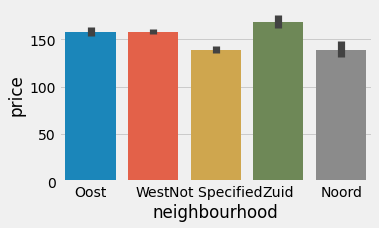

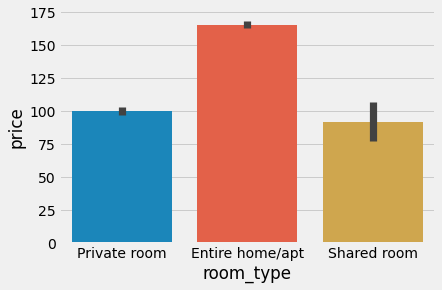

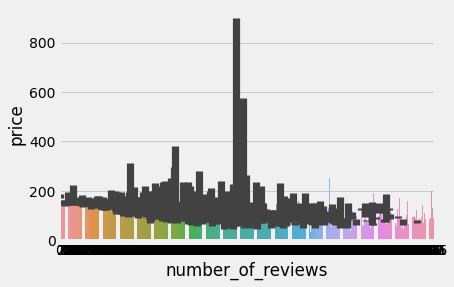

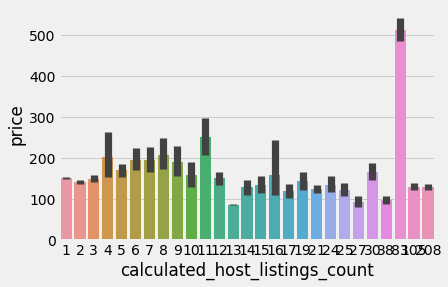

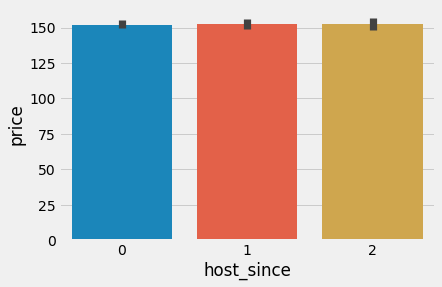

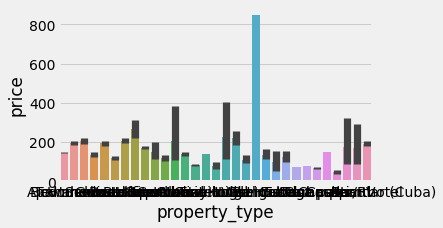

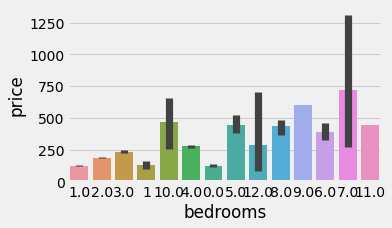

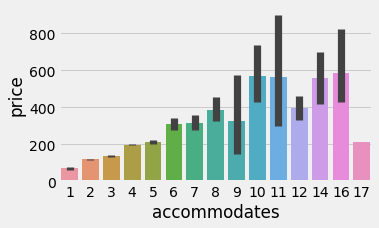

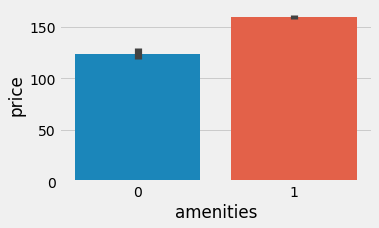

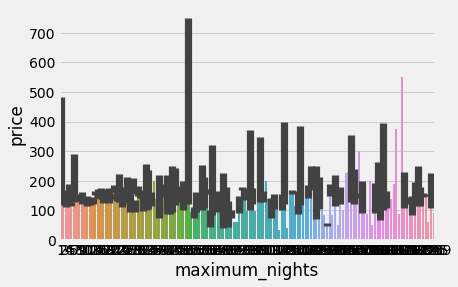

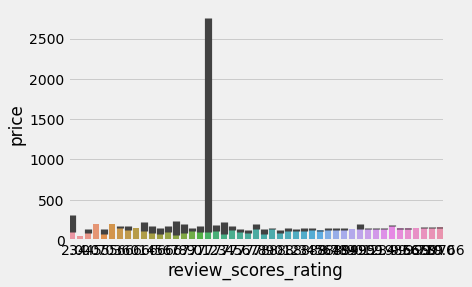

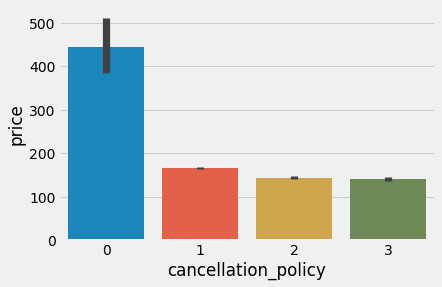

<Figure size 432x288 with 0 Axes>

In [35]:
 #we know this is not most optimal but we got stuck figuring out how to plot it elsewise 
fig = plt.figure()
fig.set_size_inches(5,3)

#shows the average price of people in each neighbourhood
sns.barplot(x=merged_df["neighbourhood"],y= merged_df["price"])
plt.show()

#shows the average price of people in each neighbourhood
sns.barplot(x=merged_df["room_type"],y= merged_df["price"])
plt.show()

#shows the average price of people in each neighbourhood
sns.barplot(x=merged_df["number_of_reviews"],y= merged_df["price"])
plt.show()

#shows the average price of people in each neighbourhood
sns.barplot(x=merged_df["calculated_host_listings_count"],y= merged_df["price"])
plt.show()

#shows the average price of people in each neighbourhood
sns.barplot(x=merged_df["host_since"],y= merged_df["price"])
plt.show()

#shows the average price of people in each property type
fig = plt.figure()
fig.set_size_inches(5,3) #change to bigger numbers to see x_labels
sns.barplot(x=merged_df["property_type"],y= merged_df["price"])
plt.show()

#shows the average price of people in each bedrooms
fig = plt.figure()
fig.set_size_inches(5,3)
sns.barplot(x=merged_df["bedrooms"],y= merged_df["price"])
plt.show()

#shows the average price of people in each accommodates
fig = plt.figure()
fig.set_size_inches(5,3)
sns.barplot(x=merged_df["accommodates"],y= merged_df["price"])
plt.show()

#this one contains one outlier var!
fig = plt.figure()
fig.set_size_inches(5,3) #change to bigger numbers to see x_labels
sns.barplot(x=merged_df["amenities"],y= merged_df["price"])
plt.show()

#shows the average price of people in each neighbourhood
sns.barplot(x=merged_df["maximum_nights"],y= merged_df["price"])
plt.show()

#shows the average price of people in each neighbourhood
sns.barplot(x=merged_df["review_scores_rating"],y= merged_df["price"])
plt.show()

#shows the average price of people in each neighbourhood
sns.barplot(x=merged_df["cancellation_policy"],y= merged_df["price"])
plt.show()

plt.tight_layout()

### 3) Type of Hosts (the people that sell the rooms)
we'll look at 2 things
- When do most hosts start an account to sell
- How many listings do hosts have

For the first part we'll be using a <b>time series</b> to check if there is any seasonality in the hosts joining Airbnb:

Using a time Series for your Data will give more insights about your data. It will tell you if most cases come from a specific moment, 
or that the data is evenly spread out across time.
<br>
Since we're dealing with rbnb prices, we are mostly concerned with checking if our assumption of seasonality is correct: (finding reocurrring patterns in a year)
<br> 
It is for example important to know that our data sets average housing price of €100/night,
might actually be a lot higher in summer periods compared to other seasons.
<br>
In our hypotheses we expect to see more listings in summer compared to other season of the year, but we'll check if this statement is correct 
<br>
Via this Time Series Analysis we'll check 2 things:
* i) are there more people joining rbnb and putting their listings on the website in summer months?
* ii) how many listings 1 host makes at a given point in time


The second point is important because it will probably tell us how many time a host can spend on 1 listing, 
which could in turn result in the quality of the listing -> result in price/review difference.

#### i) Is there seasonality?

In [36]:
link = 'https://drive.google.com/open?id=1P6XIk5tsm7QF1o05J24ykZsFT50eeYI6'
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('listings_details.csv')
df_2 = pd.read_csv("listings_details.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (87) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [37]:
#we changed the value "host since" because in our previous notebook we had changed dates to novice/intermediate/experienced, but we decided we wanted to use a time series, thats why we used old df
df_2['host_since'] = pd.to_datetime(df_2['host_since'])
df_2['first_review'] = pd.to_datetime(df_2['first_review'])

#checks the range of dates we're dealing with
print(f"Of the Airbnb hosts that are still listing on the site, the first joined on {min(df_2.host_since).strftime('%d %B %Y')}, and the most recent joined on {max(df_2.host_since).strftime('%d %B %Y')}.")

Of the Airbnb hosts that are still listing on the site, the first joined on 24 September 2008, and the most recent joined on 06 December 2018.


oldest host started in:  24-09-2008 <br>
newest host started in: 06-12-2018

In [0]:
# Creating dataframes for time series analysis
ts_host_since = pd.DataFrame(df_2.set_index('host_since').resample('MS').size())
ts_first_review = pd.DataFrame(df_2.set_index('first_review').resample('MS').size())

# Renaming columns
ts_host_since = ts_host_since.rename(columns={0: 'hosts'})
ts_host_since.index.rename('month', inplace=True)
ts_first_review = ts_first_review.rename(columns={0: 'reviews'})
ts_first_review.index.rename('month', inplace=True)


In [0]:
def decompose_time_series(df_2, title=''):
    """
    Plots the original time series and its decomposition into trend, seasonal and residual.
    """
    # Decomposing the time series
    decomposition = seasonal_decompose(df_2)
    
    # Getting the trend, seasonality and noise
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    # Plotting the original time series and the decomposition
    plt.figure(figsize=(12,8))
    plt.suptitle(title, fontsize=14, y=1)
    plt.subplots_adjust(top=0.80)
    plt.subplot(411)
    plt.plot(df_2, label='Original')
    plt.legend(loc='upper left')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='upper left')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='upper left')
    plt.tight_layout()

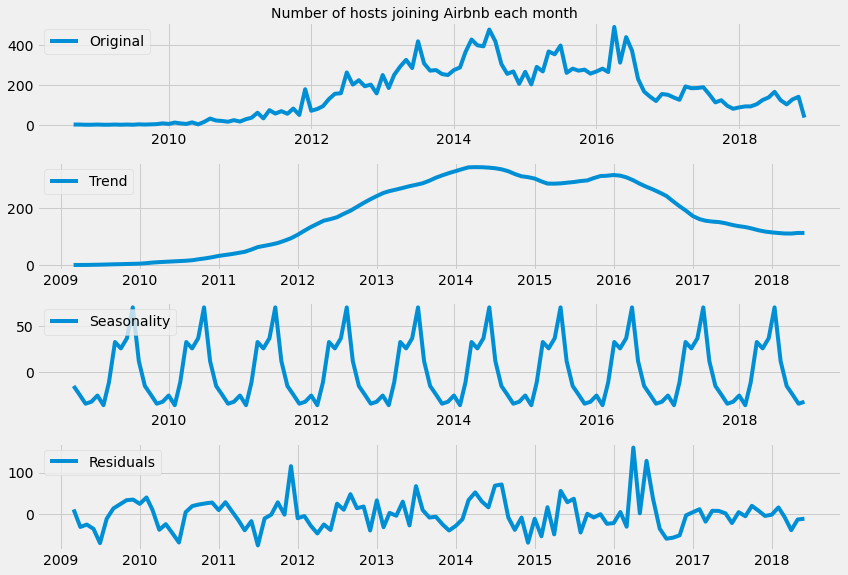

In [40]:
#we're clearly seeing seasonality implicating that more lists are hapening in the summer months of the year
decompose_time_series(ts_host_since, title='Number of hosts joining Airbnb each month')

Result  - We found Seasonality
As expected we see that their is seasonality.
* there is a peak in the summer months of the year (see graph below) for hosts to join, this might then also increase the price


#### ii) How many Listings do hosts have?

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


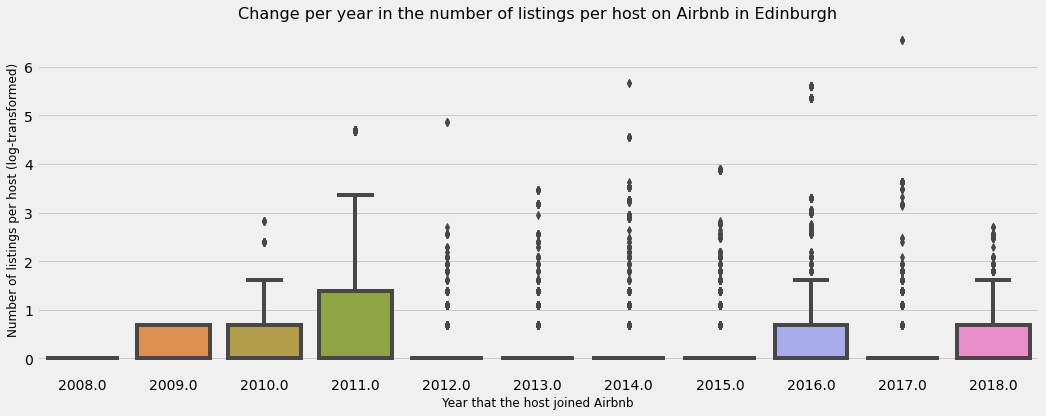

In [41]:
#since we have some missing values in 2012/2013/2014, they'll show 'empty' boxes
plt.figure(figsize=(16,6))
sns.boxplot(df_2.host_since.dt.year, np.log(df_2.host_listings_count))
plt.xlabel('Year that the host joined Airbnb', fontsize=12)
plt.ylabel('Number of listings per host (log-transformed)', fontsize=12)
plt.title('Change per year in the number of listings per host on Airbnb in Edinburgh', fontsize=16)
plt.show()

overal the amount of listings per host seem to slowly increase with the years

In [42]:
#what type of hosts?

a = df_2.sort_values('host_listings_count').drop_duplicates('host_listings_count',keep='last').tail(10)[['host_since', 'host_listings_count']]
a.sort_values("host_since")
#shows hosts with most listings ascending/year -> we're seeing an increasing trent in amnt listing/host -> So there are outliers!

#List of the largest host_listings_count (left is id number) and the year the host joined Airbnb

,host_since,host_listings_count
18314,2011-04-18,108.0
6779,2011-12-02,109.0
17880,2012-07-07,130.0
13854,2014-08-12,287.0
16028,2014-08-28,96.0
7060,2015-10-16,49.0
16841,2016-04-05,213.0
17038,2016-06-06,271.0
16053,2017-03-22,698.0
14903,NaT,NaN


Some hosts have up to 698 listings, but this is pretty uncommon

most of the times the rbnb host only has a few listings (1-3), meaning that they would probably care a lot for that listing since it is one of his only incomes

## K-means cluster

K-means clustering is an unsupervised learning algorithm that will attempt to group similar clusters together in mostly unlabeled data <br> Since all our data is labeled, we'll use k-means cluster to check how good the algorithm is in predicting the labels we already have

The algorithm works as follows:
<br><br>
<b> Do: </b> 
<br>
1) pick a number of clusters "K" <br>
2) Randomly assign each point to a cluster
<br><br>
<b> Repeat:</b>
<br>
3) Compute centrod by taking the mean vector of points in the cluster <br>
4) Assign each data point to the cluster for which the centroid is closest
<br><br>
<b> Stop:</b>
when clusters dont change

All our variables have clear labels, and we don't think we really need to use k-means (most of the times people use k-means<br> when they have an attribute name but no labels in it).<br>
We will however test if our labels are correct by performing a k-means on the attribute "Neighbourhood (5 labels in this var)"


In [43]:
from sklearn.cluster import KMeans

#we expect 5 labels | North/East/South/West |
kmeans = KMeans(n_clusters=5)

#.. doing k means with numerical values dataset
clusterdata1 = merged_df.dropna()
clusterdata2= clusterdata1.drop("cancellation_policy",axis=1)
clusterdata = clusterdata2[["neighbourhood","number_of_reviews","calculated_host_listings_count","accommodates","maximum_nights"]]

#drop because we need to predict this
kmeans.fit(clusterdata.drop("neighbourhood",axis=1))


#what are the cluster center vectors?
kmeans.cluster_centers_

array([[1.90730280e+01, 2.59174951e+00, 2.89240918e+00, 1.12476577e+03],
       [1.63228200e+01, 1.49499072e+00, 2.88893012e+00, 2.45439703e+01],
       [2.61555556e+01, 6.35251462e+01, 3.07953216e+00, 3.69424561e+02],
       [7.00000000e+00, 1.00000000e+00, 3.00000000e+00, 9.99900000e+03],
       [2.21573620e+02, 1.65337423e+00, 2.45705521e+00, 4.08036810e+01]])

### Evaluation of the K-means algorit


In [0]:
#creating a confusion matrix
from sklearn.metrics import confusion_matrix,classification_report

In [45]:
#creating a confusion matrix
from sklearn.metrics import confusion_matrix,classification_report

clusterdata["neighbourhood"] =  merged_df["neighbourhood"]
clusterdata.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,neighbourhood,number_of_reviews,calculated_host_listings_count,accommodates,maximum_nights
0,Oost,248,1,2,15
1,West,42,1,5,20
2,Oost,233,2,2,1000
3,West,1,2,3,60
4,West,171,1,2,730


In [0]:
# print(confusion_matrix(clusterdata["neighbourhood"],kmeans.labels_))
# print("\n")
# print(classification_report(clusterdata["neighbourhood"],kmeans.labels_))

## Correlations and further analysis of variables

In [47]:
merged_df.columns

Index(['price', 'neighbourhood', 'room_type', 'property_type', 'host_since',
       'calculated_host_listings_count', 'guests_included', 'accommodates',
       'bedrooms', 'bathrooms', 'bed_type', 'amenities', 'minimum_nights',
       'maximum_nights', 'availability_365', 'cancellation_policy',
       'number_of_reviews', 'review_scores_rating', 'last_review',
       'reviews_per_month'],
      dtype='object')

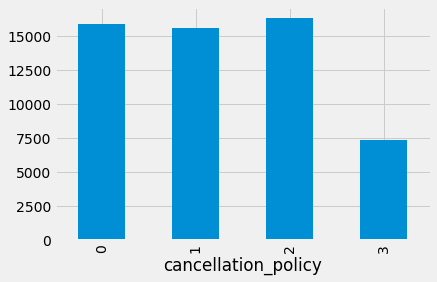

In [48]:
count_values = merged_df[['neighbourhood','room_type','last_review','host_since','property_type','bathrooms','cancellation_policy']]

count_values.groupby('neighbourhood').size().plot.bar()
count_values.groupby('room_type').size().plot.bar()
count_values.groupby('last_review').size().plot.bar()
count_values.groupby('host_since').size().plot.bar()
count_values.groupby('property_type').size().plot.bar()
count_values.groupby('bathrooms').size().plot.bar()
count_values.groupby('cancellation_policy').size().plot.bar()

In [49]:
merged_df[['price','minimum_nights','number_of_reviews','availability_365','review_scores_rating']].describe()

,price,minimum_nights,number_of_reviews,availability_365,review_scores_rating
count,20030.000000,20030.000000,20030.000000,20030.000000,20030.000000
mean,152.181178,3.328707,21.560459,59.913679,9.484952
std,145.828976,12.537419,43.240292,104.027710,0.619521
min,0.000000,1.000000,0.000000,0.000000,2.000000
25%,96.000000,2.000000,3.000000,0.000000,9.300000
50%,125.000000,2.000000,8.000000,3.000000,9.600000
75%,175.000000,3.000000,22.000000,67.000000,9.900000
max,8500.000000,1001.000000,695.000000,365.000000,10.000000


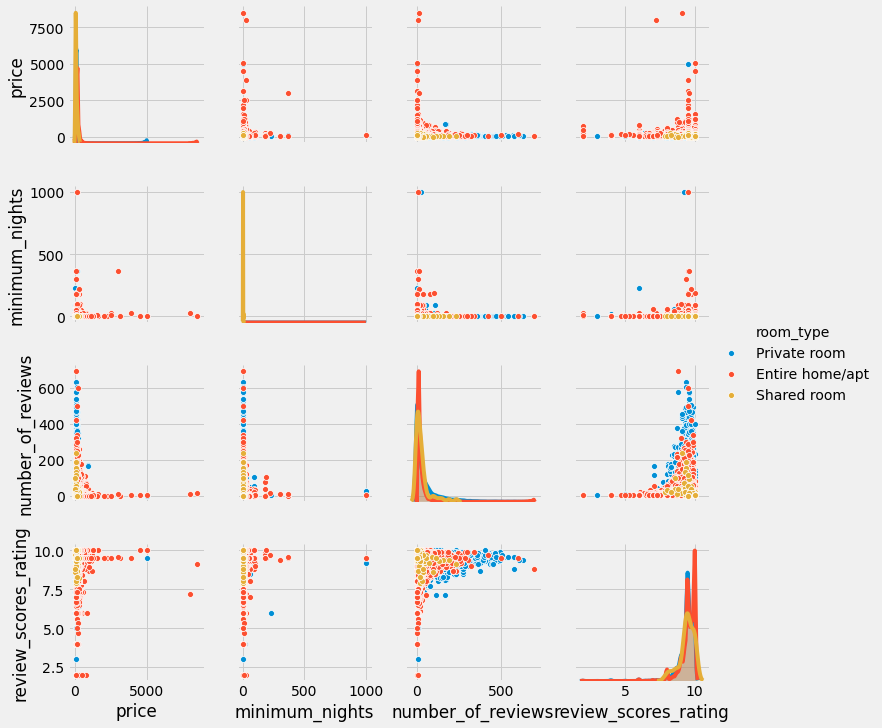

In [50]:
number_data_room_type = merged_df[['room_type','price','minimum_nights','number_of_reviews','review_scores_rating']]
sns.pairplot(number_data_room_type, hue='room_type')

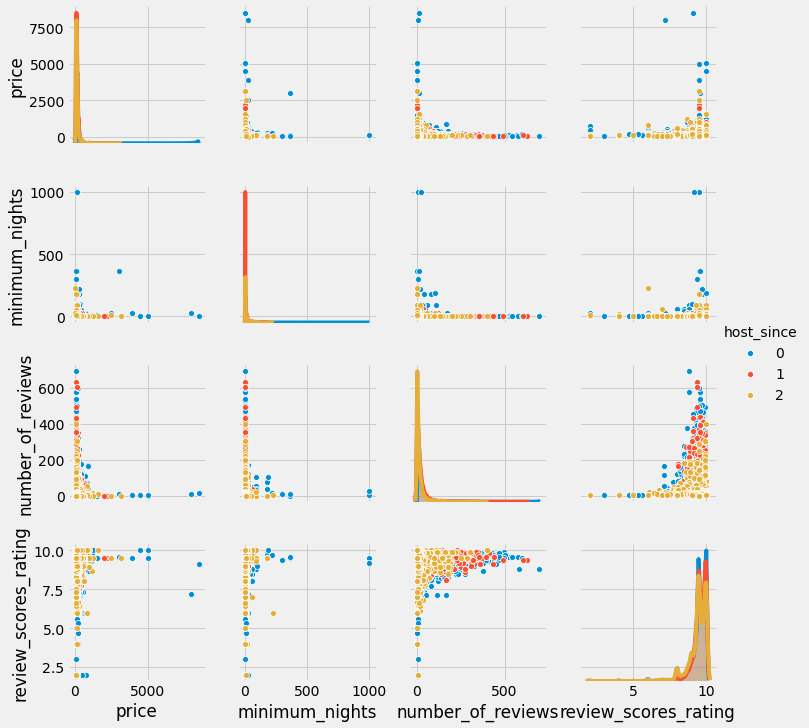

In [51]:
number_data_host_since = merged_df[['host_since','price','minimum_nights','number_of_reviews','review_scores_rating']]
sns.pairplot(number_data_host_since, hue='host_since')

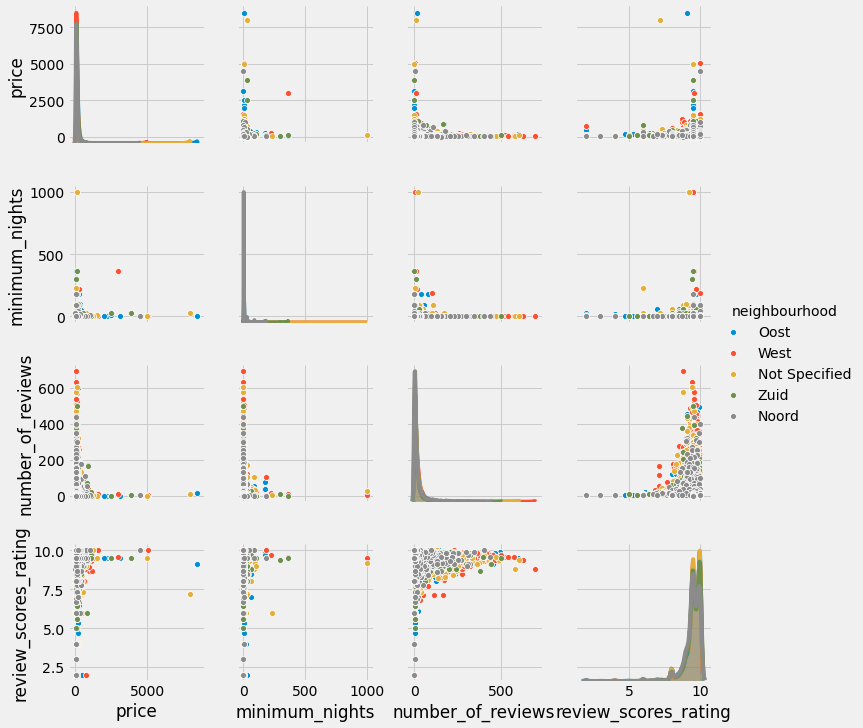

In [52]:
number_data_neighbourhood = merged_df[['neighbourhood','price','minimum_nights','number_of_reviews','review_scores_rating']]
sns.pairplot(number_data_neighbourhood, hue='neighbourhood')

In [53]:
number_data_room_type = merged_df[['room_type','price','minimum_nights','number_of_reviews','availability_365','accommodates','bathrooms','bedrooms','amenities','guests_included','review_scores_rating']]
number_data_room_type = number_data_room_type.fillna(number_data_room_type.mean())
round(number_data_room_type.describe(),2)

,price,minimum_nights,number_of_reviews,availability_365,accommodates,amenities,guests_included,review_scores_rating
count,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00,20030.00
mean,152.18,3.33,21.56,59.91,2.89,0.79,1.47,9.48
std,145.83,12.54,43.24,104.03,1.32,0.41,0.94,0.62
min,0.00,1.00,0.00,0.00,1.00,0.00,1.00,2.00
25%,96.00,2.00,3.00,0.00,2.00,1.00,1.00,9.30
50%,125.00,2.00,8.00,3.00,2.00,1.00,1.00,9.60
75%,175.00,3.00,22.00,67.00,4.00,1.00,2.00,9.90
max,8500.00,1001.00,695.00,365.00,17.00,1.00,16.00,10.00


                         price  ...  review_scores_rating
price                 1.000000  ...              0.025585
minimum_nights        0.039119  ...             -0.002363
number_of_reviews    -0.067417  ...              0.005803
availability_365      0.159293  ...             -0.018600
accommodates          0.356543  ...             -0.037460
amenities             0.099606  ...              0.055518
guests_included       0.160935  ...             -0.002000
review_scores_rating  0.025585  ...              1.000000

[8 rows x 8 columns]


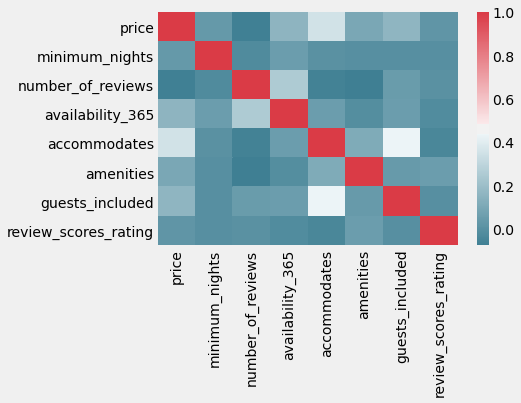

In [54]:
corr = number_data_room_type.corr()
print(corr)
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap=sns.diverging_palette(220, 10, as_cmap=True))

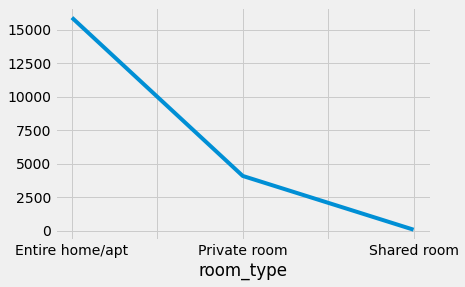

In [55]:
merged_df.groupby('room_type').size().plot()

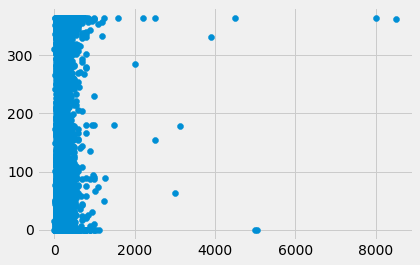

In [56]:
plt.scatter(number_data_room_type['price'],number_data_room_type['availability_365'])

Checking for PCA

In [57]:
X = number_data_room_type.drop(['room_type','guests_included','amenities','bathrooms','bedrooms','accommodates','minimum_nights','number_of_reviews','availability_365'],axis=1)
X.columns

Index(['price', 'review_scores_rating'], dtype='object')

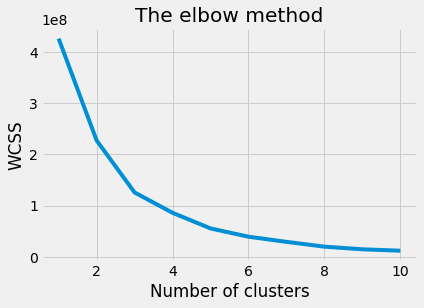

In [58]:
#Finding the optimum number of clusters for k-means classification
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares
plt.show()

In [59]:
for n_cluster in range(2, 11):
    kmeans = KMeans(n_clusters=n_cluster).fit(X)
    label = kmeans.labels_
    sil_coeff = silhouette_score(X, label, metric='euclidean')
    print("For n_clusters={}, The Silhouette Coefficient is {}".format(n_cluster, sil_coeff))

For n_clusters=2, The Silhouette Coefficient is 0.9821726985554319
For n_clusters=3, The Silhouette Coefficient is 0.7126755619134396
For n_clusters=4, The Silhouette Coefficient is 0.6160698896862525
For n_clusters=5, The Silhouette Coefficient is 0.6164220063443805
For n_clusters=6, The Silhouette Coefficient is 0.575836255065062
For n_clusters=7, The Silhouette Coefficient is 0.5533132401369504
For n_clusters=8, The Silhouette Coefficient is 0.5665530218429727
For n_clusters=9, The Silhouette Coefficient is 0.5609132798542809
For n_clusters=10, The Silhouette Coefficient is 0.5662258793252732


In [60]:
#Applying kmeans to the dataset / Creating the kmeans classifier
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans = kmeans.fit_predict(X)
num0 = y_kmeans==0
sum(num0)
num1 = y_kmeans==1
print(sum(num1))
num2 = y_kmeans==2
sum(num2)

2320


8

In [0]:
##Visualising the clusters
#plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'magenta', label = 'Entire home/apt')
#plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'cyan', label = 'Private room')
#plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = 'orange', label = 'Shared room')

##Plotting the centroids of the clusters
#plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:,1], s = 100, c = 'black', label = 'Centroids')

#plt.legend()

# PCA Analysis

In [0]:
dataPCA = data1.copy()

X1 = dataPCA.drop(['price'],axis=1)
y1 = dataPCA['price']

In [0]:
from sklearn.preprocessing import StandardScaler
X1 = StandardScaler().fit_transform(X1)

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X1)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [65]:
finalDf = pd.concat([principalDf, dataPCA[['price']]], axis = 1)
finalDf

,principal component 1,principal component 2,price
0,-3.704880,2.661565,cheap
1,0.607435,0.753288,expensive
2,-1.995546,3.377250,cheap
3,0.549247,-0.432370,mid-range
4,-2.899878,2.772198,expensive
...,...,...,...
20025,1.866757,1.527862,very-expensive
20026,0.430989,-0.486596,expensive
20027,-0.473419,-0.345887,cheap
20028,-1.451955,-0.464354,cheap


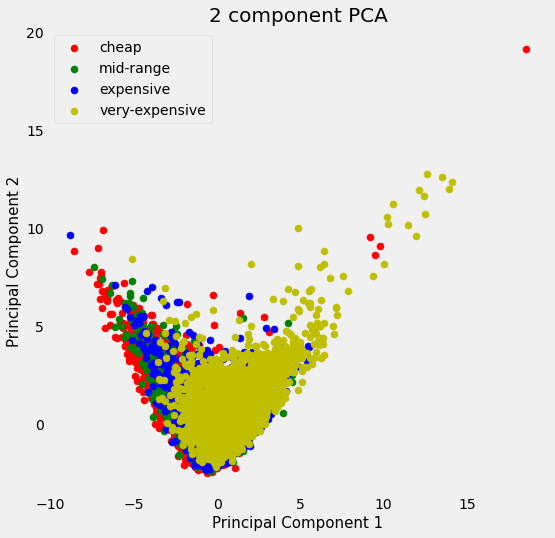

In [66]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = ['cheap', 'mid-range', 'expensive', 'very-expensive']
colors = ['r', 'g', 'b', 'y']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['price'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

In [67]:
pca.explained_variance_ratio_

array([0.11862389, 0.09960474])

PCA to Speed-up Machine Learning Algorithms

In [0]:
from sklearn.model_selection import train_test_split
# test_size: what proportion of original data is used for test set
train_X, test_X, train_y, test_y = train_test_split(X1, y1, test_size=1/7.0, random_state=0)

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(train_X)
# Apply transform to both the training set and the test set.
train_X = scaler.transform(train_X)
test_X = scaler.transform(test_X)

In [0]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.95)

In [71]:
pca.fit(train_X)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [0]:
train_X = pca.transform(train_X)
test_X = pca.transform(test_X)

Logistic regression for transformed data

In [0]:
from sklearn.linear_model import LogisticRegression
# all parameters not specified are set to their defaults
# default solver is incredibly slow which is why it was changed to 'lbfgs'
logisticRegr = LogisticRegression(solver = 'lbfgs')

In [74]:
logisticRegr.fit(train_X, train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [75]:
# Predict for One Observation (image)
logisticRegr.predict(test_X[0].reshape(1,-1))

array(['very-expensive'], dtype=object)

In [76]:
# Predict for One Observation (image)
logisticRegr.predict(test_X[0:10])

array(['very-expensive', 'very-expensive', 'expensive', 'cheap',
       'mid-range', 'very-expensive', 'cheap', 'mid-range', 'cheap',
       'cheap'], dtype=object)

In [77]:
logisticRegr.score(test_X, test_y)

0.4944095038434661

# Overal Factor Analysis

## Factor Analysis

* Factor Analysis is an exploratory data analysis method used to search influential underlying factors or latent variables from a set of observed variables.<br>
* It helps in data interpretations by reducing the number of variables. <br>
* It extracts maximum common variance from all variables and puts them into a common score.

# Assumptions of Factor Analysis
* There are no outliers in data. <br>
=> we have a few but not that much! <br><br>
* Sample size should be greater than the factor.<br>
=> Sample is 20k, factor is 5 so True<br><br>
* There should not be perfect multicollinearity.<br>
=> Accomodates had the highest correlation of numeric val of 0.35 so True<br><br>
* There should not be homoscedasticity between the variables.<br>
=>True, not all variables have same variance!
<br><br>

Thus we can use factor analysis<br><br>

# Step-By-Step
1 Factoranal DataFrame
* As factor analysis can only be done with ordinal/numeric values, we transformed all ordinal variables into integers (1..2..3 etc)
* In the factoranal dataframe we thus dropped categorical nominal variables
2 Scree plot
* Via the scree plot we can see the amount of factors needed (5) => based on the EIGENVALUE > 1 RULE

<br><br>
2 Fit Model
* We made the factor analysis model fit on our factoranal data frame via scikitlearn
<br><br>
3 Interpret Results
* The variables in factor 1 are indicating price/size of a room!!!.
* guests_included basically means: how many guests are included for the booking fee -> basically indicating how many guests there are (accomodates) -> inidicating size room -> indicating prize
<br>
We somehow missed that accomodates and guests_included mean the same thing, thus via this pca we will remove guests_included since it had the least amount of loading

<br><br>
3 Conclusions
*  we find that the total amount of variance explained by our 5 factors is 0.37%
* this means that 45% of the variables explain 37% of the variance (note that this is pretty good since there is a lot of error aswell) 
<br>However since we only have 11 variables anyways, we think that only dropping the 'duplicate' variable "guests_included" will be enough.<br>
<br>this way our models still have a lot of variance to work with


In [0]:
#we create 
factoranal_df = complete_df.copy()
factoranal_df = factoranal_df[["minimum_nights","number_of_reviews","calculated_host_listings_count","availability_365","host_since","accommodates","amenities","guests_included","maximum_nights","cancellation_policy","price"]]

In [79]:
factoranal_df

,minimum_nights,number_of_reviews,calculated_host_listings_count,availability_365,host_since,accommodates,amenities,guests_included,maximum_nights,cancellation_policy,price
0,3,248,1,44,0,2,0,1,15,1,59
1,4,42,1,47,0,5,0,2,20,2,160
2,1,233,2,198,0,2,1,2,1000,1,80
3,14,1,2,141,0,3,1,2,60,1,125
4,2,171,1,199,0,2,1,1,730,1,150
...,...,...,...,...,...,...,...,...,...,...,...
20025,7,0,1,11,0,4,1,1,12,1,340
20026,3,0,2,16,0,3,1,1,14,3,150
20027,10,0,2,210,2,2,1,1,22,2,80
20028,2,0,2,31,0,2,1,1,15,3,55


In [80]:
!pip install factor_analyzer
from factor_analyzer import FactorAnalyzer
fa = FactorAnalyzer(n_factors=5, rotation="varimax") #p
fa.fit(factoranal_df)
#get the loadings
loadings = fa.loadings_
#get he eigenvectors and eigenvalues
ev, v = fa.get_eigenvalues()
#scree plot
xvalues = range(1,factoranal_df.shape[1]+1)

     |████████████████████████████████| 40kB 2.0MB/s 
  Created wheel for factor-analyzer: filename=factor_analyzer-0.3.2-cp36-none-any.whl size=40380 sha256=f83f6b98079118148b30424ab7e95e0712e8e7cc3b1192e7fedc04af8b781b2e
  Stored in directory: /root/.cache/pip/wheels/4a/d0/57/f1330cb9c80e82d8d05391c74c94ed61ce3f03bf6157f3d6db
Successfully built factor-analyzer


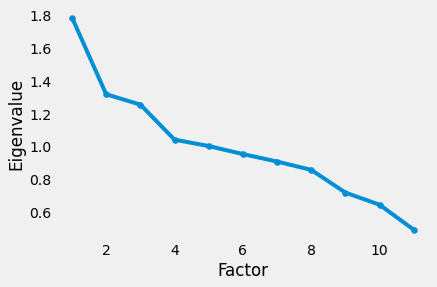

In [81]:
plt.scatter(xvalues,ev)
plt.plot(xvalues,ev)
plt.title=("Scree Plot")
plt.xlabel("Factor")
plt.ylabel("Eigenvalue")
plt.grid()
plt.show()
#eigenvalue bigger than 1 rule
#or elbow method both gives 4-5 factors 

In [0]:
factorloadings = pd.DataFrame.from_records(loadings)
#factorloadings

In [83]:
#choose factorloadings > 0.3 
df = pd.DataFrame({'variable': [ "minimum_nights","number_of_reviews","calculated_host_listings_count","availability_365","host_since","accommodates","amenities","guests_included","maximum_nights","cancellation_policy","price"]})
factorloadings =factorloadings[factorloadings>0.3]
factorloadings["variable"] = df
factorloadings.set_index('variable')

,0,1,2,3,4
variable,,,,,
minimum_nights,NaN,NaN,NaN,NaN,NaN
number_of_reviews,NaN,NaN,NaN,NaN,NaN
calculated_host_listings_count,NaN,NaN,0.985493,NaN,NaN
availability_365,NaN,0.989682,NaN,NaN,NaN
host_since,NaN,NaN,NaN,NaN,NaN
accommodates,0.952177,NaN,NaN,NaN,NaN
amenities,NaN,NaN,NaN,NaN,NaN
guests_included,0.470661,NaN,NaN,NaN,NaN
maximum_nights,NaN,NaN,NaN,NaN,NaN


## Factors
<t> Factor 1:
   * accomodates
   * guests_included
   * price
   <br><br>
Factor 2:
   * availability
   <br>
   Factor 3:
   * calculated_host_listings_count
   <br><br>
   Factor 4:
   * cancellation policy
   <br><Br>
   Factor 5:
   * nothing is bigger than 0.3 -> implies that there are only 4 factors
   <br>
   
 The variables in factor 1 are indicating price/size of a room!!!. <br>
 We can conclude that however price is our dependent variable. <br><br>
 We didn't think that we needed to remove this variable at first, but after the PCA it makes sense to remove this var because it basically indicates how many people are included in the hotel (acoomodations)
 
 accomodates and guests included could 

In [84]:
#column [2][4] describes the total var explained by the factor analyses 5 factors
cumulative_var_5_factor= pd.DataFrame(fa.get_factor_variance())
cumulative_var_5_factor

,0,1,2,3,4
0,1.289914,1.057391,1.036130,0.341255,0.333119
1,0.117265,0.096126,0.094194,0.031023,0.030284
2,0.117265,0.213391,0.307585,0.338608,0.368892


In [85]:
#total amount of variance explained by the 5 factprs
cumulative_var_5_factor.iloc[2][4]

0.3688917267106918

# Overal Decision Tree

## Decision Tree
<br>

This section will discuss the working of a decision tree in generar.<br><br>
The following explanation about the structure of a decision tree is given by Hunt (1962) in one of the earliest papers about decision trees:<br>
* Let Dt be the set of training records that reaches a node t. 
* If Dt contains records that belong to the same class, let that class be called Yt, then t is a leaf node labelled as Yt. 
* If Dt is an empty set or the attribute values are the same, then t is a leaf node labelled by the default class, Yd (the majority class for the parent Dt). 
* If Dt contains records that belong to more than one class, use an attribute test (this differs for different data types) to split the data into smaller subsets. 
* Recursively apply this procedure to each subset.
<br><br>
Following this algorithm produces a decision tree. <br>
A decision tree is a tree-like graph system that is used to learn a classification function which concludes the value of a dependent attribute given the values of the independent input variables

# J48 Decision Tree
A major task of a decision tree, is determining on which attribute to split next. <br>
J48 uses entropy (entropy measures the homogeneity of a node) to decide on which attribute to split next. 

Formula 1 shows how to calculate the entropy on the dataset.
<br><br>
1.  Entropy(t)= $\sum_{j}$ 𝑝(𝑗|𝑡) 𝑙𝑜𝑔2 𝑝(𝑗|𝑡)                 
<br><br>
Here p(j|t) is the relative frequency of class j at node t. Entropy ranges from 0.0 (where all tuples belong to one class, which implies the most information gain), to 1.0 (the tuples are split evenly between the classes). 
<br> Once the Entropy for every leaf, coming from a parent node is calculated, the average Entropy gain (information gain) for splitting a certain parent attribute into x amount of leaves, can be calculated with formula 2:
<br><br>
2. 𝐺𝐴𝐼𝑁𝑠𝑝𝑙𝑖𝑡=Entropy (p) − ( $\sum_{i=1}^k$ 𝑛𝑖/𝑛 * 𝐸𝑛𝑡𝑟𝑜𝑝𝑦(𝑖) )      
<br><br>
Here p is a parent node (that is split into k partitions). <br>
𝑛𝑖/n is the number of tuples in partition i, divided by the total amount of tuples that reached the parent node.
<br>However, instead of information gain (Gain split) the current j48 decision tree uses gain ratio. 
<br>This is a slightly more optimised measure to decide on which attribute to split compared to the standard information gain. 
<br>This is because it gives a higher entropy to decision trees with a lot of small partitions. 
<br>In data mining complex trees are often times avoided because attribute splits into a lot of different leaves tend to produce models that overfit. 
<br>This is because the more complex a model becomes, the smaller the amount of tuples become that reach a specific leaf node. 
<br>A small amount of tuples per leaf node means that there is a high chance that noise, or just simply variance dominates the classifier.
<br>The following formula attempt to solve this problem by calculating the gain ratio instead.
<br><br>
3. SplitINFO=−  $\sum_{i=1}^k$ * 𝑛𝑖/𝑛 * 𝑙𝑜𝑔2 * 𝑛i/𝑛



In [0]:
decision_tree_df = complete_df.copy()

In [0]:
def Price_TO_Category(x): #decision tree can only use categoric value
    """
    transforms dependent variable price/day into 4 equal groups:
    1 cheap       price < €96
    2 mid-range   96  < price <= 125
    3 expensive   125 < price <= 175
    4 overpriced  price > 175
    """
    if  x <=96:
        return 1                   #cheap
    if  x > 96 and x <= 125:
         return 2                  #mid-range
    if  x > 125 and x <= 175:
         return 3                  #expensive
    if x >175:
        return 4                   #overpriced
    
decision_tree_df["price"] = decision_tree_df["price"].apply(Price_TO_Category)


def transform_neighbourhood(x):
    """transforms neighbourhood into 4 categories
        Noord = 1
        East  = 2
        West  = 3
        Zuid  = 4
     """
    if  x.__contains__("Noord"):
        return 1
    if  x.__contains__("Oost"):
        return 2
    if  x.__contains__("Zuid"):
        return 3
    if  x.__contains__("West"):
        return 4
    else:
        return 5
    
decision_tree_df["neighbourhood"] = decision_tree_df["neighbourhood"].apply(transform_neighbourhood)


def transform_room_type(x):
    """transforms neighbourhood into 4 categories
        Noord = 1
        East  = 2
        West  = 3
        Zuid  = 4
     """
    if  x.__contains__("Private room"):
        return 1
    if  x.__contains__("Entire home/apt"):
        return 2
    if  x.__contains__("Shared room"):
        return 3

decision_tree_df["room_type"] = decision_tree_df["room_type"].apply(transform_room_type)


def property_type(x):
    """transforms neighbourhood into 4 categories
        Noord = 1
        East  = 2
        West  = 3
        Zuid  = 4
     """
    
    #house
    if  x.__contains__("Townhouse" or "houseboat" or "house" or "Tiny house" or "Earth house" or "Villa" or "Cottage"):
        return 1 
    #hotel                
    if  x.__contains__("Bed and breakfast" or "Hostel" or "Hotel" or "Aparthotel" or "Guest suite" or "Loft" or "Cabin"):
        return 2
    #apartment
    if  x.__contains__("Apartment"):
        return 3
    #something else
    else: 
        return 4
   
decision_tree_df["property_type"] = decision_tree_df["property_type"].apply(property_type)
                                                          
    
def bed_type(x):
    """transforms neighbourhood into 4 categories
        Noord = 1
        East  = 2
        West  = 3
        Zuid  = 4
     """
    if  x.__contains__("Real Bed"):
        return 1
    if  x.__contains__("Futon"):
        return 2
    if  x.__contains__("Pull-out Sofa"):
        return 3
    if  x.__contains__("Airbed"):
        return 4
    if  x.__contains__("Couch"):
        return 5

decision_tree_df["bed_type"] = decision_tree_df["bed_type"].apply(bed_type)                                                      
                                                          

In [88]:
#we split into even frequencies so zeroR accuracy would be 25%
decision_tree_df["price"].value_counts()

2    5086
3    5081
1    5019
4    4844
Name: price, dtype: int64

## Training the model

In [0]:
from sklearn.tree import DecisionTreeClassifier
#independent var
X = decision_tree_df.drop("price",axis=1)

#dependent var
y = decision_tree_df["price"]

#splitting on train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#instantiating decision tree
dtree = DecisionTreeClassifier()

#fitting tree
dtree.fit(X_train,y_train)

predictions = dtree.predict(X_test)


## Results

In [90]:
print(confusion_matrix(y_test,predictions))
print("\n")
print(classification_report(y_test,predictions))

[[765 399 277 103]
 [377 525 400 227]
 [270 408 455 354]
 [115 219 373 742]]


              precision    recall  f1-score   support

           1       0.50      0.50      0.50      1544
           2       0.34      0.34      0.34      1529
           3       0.30      0.31      0.30      1487
           4       0.52      0.51      0.52      1449

    accuracy                           0.41      6009
   macro avg       0.42      0.41      0.41      6009
weighted avg       0.42      0.41      0.41      6009



In [0]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train,y_train)
rfc_pred = rfc.predict(X_test)

In [92]:
print(confusion_matrix(y_test,rfc_pred))
print("\n")
print(classification_report(y_test,rfc_pred))


[[967 379 149  49]
 [322 673 388 146]
 [163 456 525 343]
 [ 52 156 274 967]]


              precision    recall  f1-score   support

           1       0.64      0.63      0.63      1544
           2       0.40      0.44      0.42      1529
           3       0.39      0.35      0.37      1487
           4       0.64      0.67      0.65      1449

    accuracy                           0.52      6009
   macro avg       0.52      0.52      0.52      6009
weighted avg       0.52      0.52      0.52      6009



## Visualiazing regular Decision tree

In [93]:
features = list(decision_tree_df.columns[1:])
features

['neighbourhood',
 'room_type',
 'property_type',
 'host_since',
 'calculated_host_listings_count',
 'guests_included',
 'accommodates',
 'bedrooms',
 'bathrooms',
 'bed_type',
 'amenities',
 'minimum_nights',
 'maximum_nights',
 'availability_365',
 'cancellation_policy',
 'number_of_reviews',
 'review_scores_rating',
 'last_review',
 'reviews_per_month']

In [94]:
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydot 

features = list(decision_tree_df.columns[1:])
features

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


['neighbourhood',
 'room_type',
 'property_type',
 'host_since',
 'calculated_host_listings_count',
 'guests_included',
 'accommodates',
 'bedrooms',
 'bathrooms',
 'bed_type',
 'amenities',
 'minimum_nights',
 'maximum_nights',
 'availability_365',
 'cancellation_policy',
 'number_of_reviews',
 'review_scores_rating',
 'last_review',
 'reviews_per_month']

In [95]:
dot_data = StringIO()  
export_graphviz(dtree, out_file=dot_data,feature_names=features,filled=True,rounded=True)

graph = pydot.graph_from_dot_data(dot_data.getvalue())  
Image(graph[0].create_png())  

Output hidden; open in https://colab.research.google.com to view.

# Overal comparison methods

## Data1 (not too many dummies)

In [96]:
print(complete_df.groupby('neighbourhood').size())
print(complete_df.groupby('room_type').size())
print(complete_df.groupby('property_type').size())
print(complete_df.groupby('bed_type').size())

neighbourhood
Noord            1148
Not Specified    5781
Oost             4067
West             7331
Zuid             1703
dtype: int64
room_type
Entire home/apt    15889
Private room        4076
Shared room           65
dtype: int64
property_type
Aparthotel                   73
Apartment                 15582
Barn                          4
Bed and breakfast           455
Boat                        372
Boutique hotel               28
Bungalow                     12
Cabin                        14
Camper/RV                     2
Campsite                      2
Casa particular (Cuba)        5
Castle                        1
Chalet                        3
Condominium                 323
Cottage                      12
Earth house                   1
Guest suite                 152
Guesthouse                   43
Hostel                        4
Hotel                         7
House                      1523
Houseboat                   225
Lighthouse                    1
Loft           

In [0]:
data1 = complete_df.copy()

In [0]:
def room_type(x):
    """transforms room_type home or not home
        Entire home/apt      = 1
        Other                = 0
        """
    if  x.__contains__("Entire home/apt"):      
        return 1
    else:
      return 0

def property_type(x):
    """transforms property_type into apartment or not apartment
        Apartment      = 1
        Other          = 0
        """
    if  x.__contains__("Apartment"):      
        return 1
    else:
      return 0

def bed_type(x):
    """transforms bed_type into real bed or not real bed
        Real bed      = 1
        Other         = 0
        """
    if  x.__contains__("Real Bed"):      
        return 1
    else:
      return 0

dummiesNeigh = pd.get_dummies(data1['neighbourhood']).iloc[:,1:]

In [0]:
data1["room_type"] = data1["room_type"].apply(room_type)
data1["property_type"] = data1["property_type"].apply(property_type)
data1["bed_type"] = data1["bed_type"].apply(property_type)
data1 = pd.concat([data1, dummiesNeigh], axis=1) #this Noord as 0
data1 = data1.drop(['neighbourhood'],axis=1)
data1["bedrooms"] = data1.bedrooms.astype(float)
data1["bathrooms"] = data1.bathrooms.astype(float)

### Random split train/test

In [0]:
X1 = data1.drop(['price'],axis=1)
y1 = data1['price']

In [0]:
y1 = y1.drop(7234)
y1 = y1.drop(127)
y1 = y1.drop(19486)
y1 = y1.drop(13009)
y1 = y1.drop(3321)
y1 = y1.drop(16959)
y1 = y1.drop(10008)


X1 = X1.drop(7234)
X1 = X1.drop(127)
X1 = X1.drop(19486)
X1 = X1.drop(13009)
X1 = X1.drop(3321)
X1 = X1.drop(16959)
X1 = X1.drop(10008)

In [0]:
from sklearn.model_selection import train_test_split

X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size=0.2, random_state=0)

In [0]:
# Saving feature names for later use
feature_list1 = list(X1.columns)

### Manual split train/test (commented)

In [0]:
# train_data1 = data1[:10030]
# forecast_data1 = data1[10030:]
# forecast_data1 = forecast_data1.reset_index().drop(['index'],axis=1)

In [0]:
# X_train1 = train_data1.drop(['price'],axis=1)
# y_train1 = train_data1['price']

# X_test1 = forecast_data1.drop(['price'],axis=1)
# y_test1 = forecast_data1['price']

## Data2 lots of dummies (no need to use it)

First created this split with a lot of dummies, however, does not show to be useful

In [0]:
data2 = complete_df.copy()

In [0]:
dummiesRoom = pd.get_dummies(data2['room_type']).iloc[:,1:]
dummiesProp = pd.get_dummies(data2['property_type']).iloc[:,1:]
dummiesBed = pd.get_dummies(data2['bed_type']).iloc[:,1:]
dummiesNeigh = pd.get_dummies(data2['neighbourhood']).iloc[:,1:]

In [108]:
complete_df

,price,neighbourhood,room_type,property_type,host_since,calculated_host_listings_count,guests_included,accommodates,bedrooms,bathrooms,bed_type,amenities,minimum_nights,maximum_nights,availability_365,cancellation_policy,number_of_reviews,review_scores_rating,last_review,reviews_per_month
0,59,Oost,Private room,Apartment,0,1,1,2,1,1.5,Real Bed,0,3,15,44,1,248,9.700000,1,2.10000
1,160,West,Entire home/apt,Apartment,0,1,2,5,2,1,Real Bed,0,4,20,47,2,42,9.600000,1,1.03000
2,80,Oost,Entire home/apt,Townhouse,0,2,2,2,1,1,Real Bed,1,1,1000,198,1,233,8.700000,1,2.18000
3,125,West,Entire home/apt,Apartment,0,2,2,3,1,1,Real Bed,1,14,60,141,1,1,10.000000,1,0.09000
4,150,West,Private room,Houseboat,0,1,1,2,1,1,Real Bed,1,2,730,199,1,171,9.900000,1,2.03000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20025,340,Not Specified,Entire home/apt,House,0,1,1,4,3,2,Real Bed,1,7,12,11,1,0,9.484952,0,1.06208
20026,150,Oost,Entire home/apt,Apartment,0,2,1,3,2,1,Real Bed,1,3,14,16,3,0,9.484952,0,1.06208
20027,80,Oost,Entire home/apt,Apartment,2,2,1,2,1,1,Real Bed,1,10,22,210,2,0,9.484952,0,1.06208
20028,55,Oost,Private room,Apartment,0,2,1,2,1,1,Real Bed,1,2,15,31,3,0,9.484952,0,1.06208


In [0]:
data2 = pd.concat([data2, dummiesRoom], axis=1) #this Noord as 0
data2 = pd.concat([data2, dummiesProp], axis=1) #this Noord as 0
data2 = pd.concat([data2, dummiesBed], axis=1) #this Noord as 0
data2 = pd.concat([data2, dummiesNeigh], axis=1) #this Noord as 0
data2 = data2.drop(['neighbourhood','room_type','property_type','bed_type'],axis=1)

In [110]:
data2

,price,host_since,calculated_host_listings_count,guests_included,accommodates,bedrooms,bathrooms,amenities,minimum_nights,maximum_nights,availability_365,cancellation_policy,number_of_reviews,review_scores_rating,last_review,reviews_per_month,Private room,Shared room,Apartment,Barn,Bed and breakfast,Boat,Boutique hotel,Bungalow,Cabin,Camper/RV,Campsite,Casa particular (Cuba),Castle,Chalet,Condominium,Cottage,Earth house,Guest suite,Guesthouse,Hostel,Hotel,House,Houseboat,Lighthouse,Loft,Nature lodge,Other,Serviced apartment,Tent,Tiny house,Townhouse,Villa,Couch,Futon,Pull-out Sofa,Real Bed,Not Specified,Oost,West,Zuid
0,59,0,1,1,2,1,1.5,0,3,15,44,1,248,9.700000,1,2.10000,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
1,160,0,1,2,5,2,1,0,4,20,47,2,42,9.600000,1,1.03000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,80,0,2,2,2,1,1,1,1,1000,198,1,233,8.700000,1,2.18000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0
3,125,0,2,2,3,1,1,1,14,60,141,1,1,10.000000,1,0.09000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
4,150,0,1,1,2,1,1,1,2,730,199,1,171,9.900000,1,2.03000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20025,340,0,1,1,4,3,2,1,7,12,11,1,0,9.484952,0,1.06208,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
20026,150,0,2,1,3,2,1,1,3,14,16,3,0,9.484952,0,1.06208,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
20027,80,2,2,1,2,1,1,1,10,22,210,2,0,9.484952,0,1.06208,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0
20028,55,0,2,1,2,1,1,1,2,15,31,3,0,9.484952,0,1.06208,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0


### Random split train/test

In [0]:
X2 = data2.drop(['price'],axis=1)
y2 = data2['price']

In [0]:
from sklearn.model_selection import train_test_split

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=0)

In [0]:
# Saving feature names for later use
feature_list2 = list(X2.columns)

### Manual split train/test (commented)

In [0]:
# train_data2 = data2[:10030]
# forecast_data2 = data2[10030:]
# forecast_data2 = forecast_data2.reset_index().drop(['index'],axis=1)

In [0]:
# X_train2 = train_data2.drop(['price'],axis=1)
# y_train2 = train_data2['price']

# X_test2 = forecast_data2.drop(['price'],axis=1)
# y_test2 = forecast_data2['price']

## Different models

In [0]:
# Load Library
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn import metrics
import statsmodels.api as sm

OLS

In [117]:
model = sm.OLS(y_train1, X_train1)
results = model.fit()
y_pred = results.predict(X_test1)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test1, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test1, y_pred)))

Mean Absolute Error: 44.387095683065546
Root Mean Squared Error: 72.99354464377575


Decision Tree model

In [118]:
clf = DecisionTreeRegressor()
clf.fit(X_train1, y_train1)
y_pred = clf.predict(X_test1)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test1, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test1, y_pred)))

Mean Absolute Error: 60.79190773437964
Root Mean Squared Error: 111.12263309634751


Random Forest model

In [119]:
clf = RandomForestRegressor(n_estimators=100, max_features="auto", random_state=0)
clf.fit(X_train1, y_train1)
y_pred = clf.predict(X_test1)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test1, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test1, y_pred)))

Mean Absolute Error: 42.405382444923646
Root Mean Squared Error: 72.89008372866198


AdaBoost model

In [120]:
clf = AdaBoostRegressor(n_estimators=100)
clf.fit(X_train1, y_train1)
y_pred = clf.predict(X_test1)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test1, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test1, y_pred)))

Mean Absolute Error: 190.76920890452283
Root Mean Squared Error: 203.1895340458061


Gradient Boosting model

In [121]:
clf = GradientBoostingRegressor(n_estimators=100)
clf.fit(X_train1, y_train1)
y_pred = clf.predict(X_test1)
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test1, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test1, y_pred)))

Mean Absolute Error: 41.09642653687813
Root Mean Squared Error: 71.23367572729096


## OLS

better use data1

In [122]:
import statsmodels.api as sm
model = sm.OLS(y_train1, X_train1)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  price   R-squared (uncentered):                   0.792
Model:                            OLS   Adj. R-squared (uncentered):              0.792
Method:                 Least Squares   F-statistic:                              2898.
Date:                Sat, 16 May 2020   Prob (F-statistic):                        0.00
Time:                        10:07:49   Log-Likelihood:                         -93572.
No. Observations:               16018   AIC:                                  1.872e+05
Df Residuals:                   15997   BIC:                                  1.873e+05
Df Model:                          21                                                  
Covariance Type:            nonrobust                                                  
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
room_type                         37.4719      1.972     19.004      0.000      33.607      41.337
property_type                    -12.9714      1.755     -7.392      0.000     -16.411      -9.532
host_since                         1.0785      0.891      1.210      0.226      -0.669       2.826
calculated_host_listings_count    -0.0182      0.030     -0.610      0.542      -0.076       0.040
guests_included                    1.2891      0.787      1.637      0.102      -0.254       2.832
accommodates                      21.6034      0.764     28.272      0.000      20.106      23.101
bedrooms                          21.0172      1.118     18.803      0.000      18.826      23.208
bathrooms                          4.4941      0.772      5.824      0.000       2.981       6.007
bed_type                        2.124e-14   7.11e-16     29.896      0.000    1.99e-14    2.26e-14
amenities                          8.2248      1.713      4.802      0.000       4.868      11.582
minimum_nights                     0.2040      0.049      4.161      0.000       0.108       0.300
maximum_nights                     0.0007      0.001      0.566      0.572      -0.002       0.003
availability_365                   0.2081      0.007     30.490      0.000       0.195       0.221
cancellation_policy               -6.7075      0.866     -7.745      0.000      -8.405      -5.010
number_of_reviews                 -0.1725      0.020     -8.504      0.000      -0.212      -0.133
review_scores_rating               0.1215      0.459      0.265      0.791      -0.778       1.021
last_review                      -12.1736      1.343     -9.062      0.000     -14.807      -9.540
reviews_per_month                  0.4612      0.727      0.635      0.526      -0.963       1.886
Not Specified                     24.0583      3.070      7.836      0.000      18.040      30.076
Oost                              43.8349      3.176     13.801      0.000      37.609      50.061
West                              49.1685      3.052     16.108      0.000      43.185      55.152
Zuid                              44.2423      3.632     12.181      0.000      37.123      51.362
==============================================================================
Omnibus:                    23018.880   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         21561860.714
Skew:                           8.190   Prob(JB):                         0.00
Kurtosis:                     181.992   Cond. No.                     1.30e+19
==============================================================================

Warnings:
[1] Standard Errors assu

In [0]:
y_pred_best_OLS = results.predict(X_test1)
epsilon = results.resid

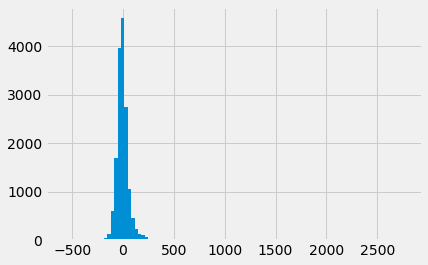

In [124]:
epsilon.hist(bins=100)

In [125]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test1, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test1, y_pred)))

Mean Absolute Error: 41.09642653687813
Root Mean Squared Error: 71.23367572729096


## Random Forest

In [0]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train1)
X_test_sc = sc.transform(X_test1)

### Long and complicated way to find best parametrization

In [0]:
# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt','log2']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# rf = RandomForestRegressor()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(X_train_sc, y_train1)

# rf_random.best_params_

In [128]:
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train_sc, y_train1)
y_pred = base_model.predict(X_test_sc)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test1, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test1, y_pred)))

# best_random = rf_random.best_estimator_
best_random = RandomForestRegressor(bootstrap=False, max_depth=30, max_features="sqrt", min_samples_leaf=2, min_samples_split=10, n_estimators=800)
best_random.fit(X_train_sc, y_train1)
y_pred_best_random_forrest = best_random.predict(X_test_sc)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_pred_best_random_forrest, y_test1))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_pred_best_random_forrest, y_test1)))

Mean Absolute Error: 45.115619318638814
Root Mean Squared Error: 78.35749146476381
Mean Absolute Error: 40.41282836246371
Root Mean Squared Error: 68.84027667617734


### Doing a simple parametrization

Checking which number of trees is better...
When checking for max_depth, unlimited is fine.

In [129]:
number_trees = (25,50,100,150,200,250,300)
len(number_trees)

7

In [0]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

number_trees = (25,50,75,100,150,200,250,300)
count = 0

RMSE_values = pd.DataFrame(np.zeros((len(number_trees),1)))
MAE_values = pd.DataFrame(np.zeros((len(number_trees),1)))

for i in number_trees:
  regressor = RandomForestRegressor(n_estimators=i, random_state=0)
  regressor.fit(X_train_sc, y_train1)
  y_pred = regressor.predict(X_test_sc)
  MAE_values.iloc[count] = metrics.mean_absolute_error(y_test1, y_pred)
  RMSE_values.iloc[count] = np.sqrt(metrics.mean_squared_error(y_test1, y_pred))
  count = count+1

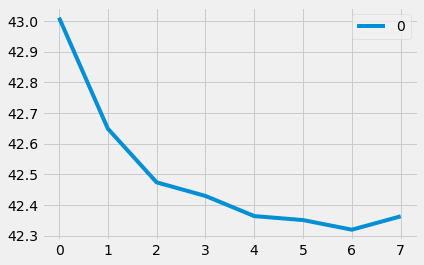

In [131]:
MAE_values.plot()

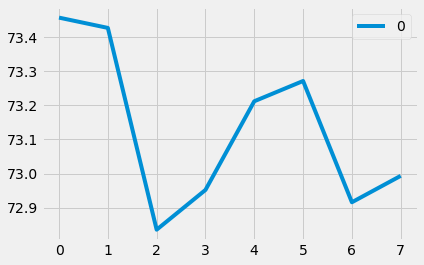

In [132]:
RMSE_values.plot()

In [0]:
# from sklearn.ensemble import RandomForestRegressor

# regressor = RandomForestRegressor(n_estimators=25, random_state=0)
# regressor.fit(X_train_sc, y_train1)
# y_pred = regressor.predict(X_test_sc)

In [0]:
# from sklearn import metrics

# print('Mean Absolute Error:', metrics.mean_absolute_error(y_test1, y_pred))
# print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test1, y_pred)))

In [135]:
# Get numerical feature importances
importances = list(best_random.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list1, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: accommodates         Importance: 0.18
Variable: availability_365     Importance: 0.15
Variable: bedrooms             Importance: 0.13
Variable: bathrooms            Importance: 0.1
Variable: minimum_nights       Importance: 0.06
Variable: guests_included      Importance: 0.05
Variable: reviews_per_month    Importance: 0.05
Variable: room_type            Importance: 0.04
Variable: number_of_reviews    Importance: 0.04
Variable: calculated_host_listings_count Importance: 0.03
Variable: maximum_nights       Importance: 0.03
Variable: review_scores_rating Importance: 0.03
Variable: host_since           Importance: 0.02
Variable: cancellation_policy  Importance: 0.02
Variable: property_type        Importance: 0.01
Variable: amenities            Importance: 0.01
Variable: last_review          Importance: 0.01
Variable: Not Specified        Importance: 0.01
Variable: Oost                 Importance: 0.01
Variable: West                 Importance: 0.01
Variable: Zuid                 

Text(0.5, 0, 'Variable')

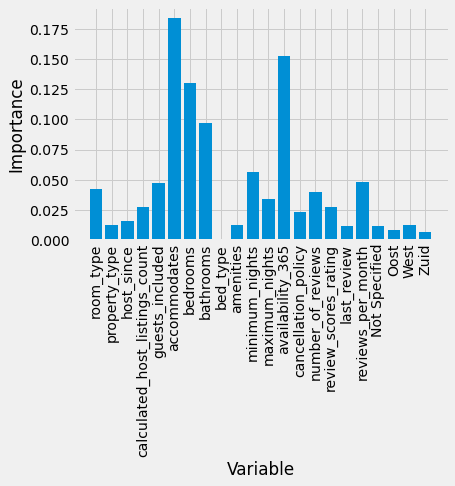

In [136]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list1, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance')
plt.xlabel('Variable')

In [137]:
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
importance_sorted = sorted(importances, reverse=True)
cumulative_importances = np.cumsum(importance_sorted)

print('Number of features for 95% importance:', np.where(cumulative_importances >= 0.95)[0][0] + 1)

Number of features for 95% importance: 17


### Graphs illustrating trees

In [0]:
from sklearn.tree import export_graphviz
import pydot

In [0]:
# # Pull out one tree from the forest
# tree = regressor.estimators_[5]
# # Export the image to a dot file
# export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list1, rounded = True, precision = 1)
# # Use dot file to create a graph
# (graph, ) = pydot.graph_from_dot_file('tree.dot')
# # Write graph to a png file
# graph.write_png('tree.png')

# # importing matplotlib modules 
# import matplotlib.image as mpimg 
# import matplotlib.pyplot as plt 
  
# # Read Images 
# img = mpimg.imread('tree.png') 
  
# # Output Images 
# plt.imshow(img) 

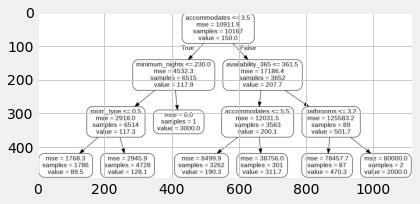

In [140]:
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(X_train1, y_train1)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list1, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

# importing matplotlib modules 
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
  
# Read Images 
img = mpimg.imread('small_tree.png') 
  
# Output Images 
plt.imshow(img) 

## Gradient Boost

In [0]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train1)
X_test_sc = sc.transform(X_test1)

### Long and complicated way to find best parametrization

In [0]:
# Load Library
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor
from sklearn import metrics
import statsmodels.api as sm

In [0]:
# from sklearn.model_selection import RandomizedSearchCV
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt','log2']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree

# learning_rate = [float(x) for x in np.linspace(start = 0, stop = 1, num = 9)]
# loss = ['ls', 'lad', 'huber', 'quantile']


# # Create the random grid
# random_grid = {'loss' : loss,
#                'learning_rate': learning_rate,
#                'n_estimators': n_estimators,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'max_features': max_features,
#                }

# # Use the random grid to search for best hyperparameters
# # First create the base model to tune
# gb = GradientBoostingRegressor()
# # Random search of parameters, using 3 fold cross validation, 
# # search across 100 different combinations, and use all available cores
# gb_random = RandomizedSearchCV(estimator = gb, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# # Fit the random search model
# gb_random.fit(X_train_sc, y_train1)

# gb_random.best_params_

In [144]:
base_model = GradientBoostingRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train_sc, y_train1)
y_pred = base_model.predict(X_test_sc)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test1, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test1, y_pred)))

# best_random = rf_random.best_estimator_
best_random_gb = GradientBoostingRegressor(learning_rate=0.125, loss='lad', max_depth=40, max_features='sqrt',
 min_samples_leaf=2, min_samples_split=10, n_estimators=2000)
best_random_gb.fit(X_train_sc, y_train1)
y_pred_best_gb = best_random_gb.predict(X_test_sc)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_pred_best_gb, y_test1))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_pred_best_gb, y_test1)))

Mean Absolute Error: 47.252334163935
Root Mean Squared Error: 77.6703883490277
Mean Absolute Error: 41.311963532494495
Root Mean Squared Error: 69.85605085544452


Checking which number of trees is better...

In [145]:
number_trees = (25,50,100,150,200,250,300)
len(number_trees)

7

In [0]:
number_trees = (25,50,75,100,150,200,250,300)
count = 0

RMSE_values = pd.DataFrame(np.zeros((len(number_trees),1)))
MAE_values = pd.DataFrame(np.zeros((len(number_trees),1)))

for i in number_trees:
  regressor = GradientBoostingRegressor(n_estimators=i)
  regressor.fit(X_train_sc, y_train1)
  y_pred = regressor.predict(X_test_sc)
  MAE_values.iloc[count] = metrics.mean_absolute_error(y_test1, y_pred)
  RMSE_values.iloc[count] = np.sqrt(metrics.mean_squared_error(y_test1, y_pred))
  count = count+1


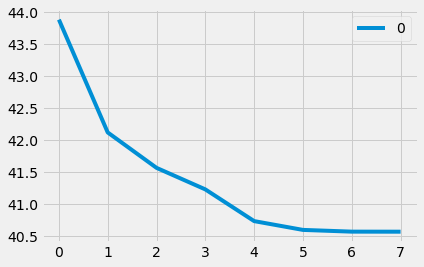

In [147]:
MAE_values.plot()

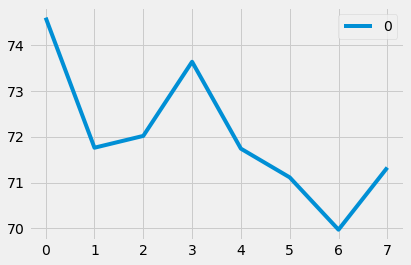

In [148]:
RMSE_values.plot()

In [0]:
# from sklearn.ensemble import GradientBoostingRegressor

# regressor = GradientBoostingRegressor(n_estimators=25)
# regressor.fit(X_train_sc, y_train1)
# y_pred_gradient_boost_best = regressor.predict(X_test_sc)

In [0]:
# from sklearn import metrics

# print('Mean Absolute Error:', metrics.mean_absolute_error(y_test1, y_pred))
# print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test1, y_pred)))

In [151]:
# Get numerical feature importances
importances = list(best_random_gb.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list1, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: reviews_per_month    Importance: 0.16
Variable: number_of_reviews    Importance: 0.13
Variable: availability_365     Importance: 0.12
Variable: review_scores_rating Importance: 0.09
Variable: maximum_nights       Importance: 0.08
Variable: minimum_nights       Importance: 0.07
Variable: accommodates         Importance: 0.04
Variable: bedrooms             Importance: 0.04
Variable: host_since           Importance: 0.03
Variable: calculated_host_listings_count Importance: 0.03
Variable: guests_included      Importance: 0.03
Variable: bathrooms            Importance: 0.03
Variable: cancellation_policy  Importance: 0.03
Variable: property_type        Importance: 0.02
Variable: amenities            Importance: 0.02
Variable: last_review          Importance: 0.02
Variable: West                 Importance: 0.02
Variable: room_type            Importance: 0.01
Variable: Not Specified        Importance: 0.01
Variable: Oost                 Importance: 0.01
Variable: Zuid                

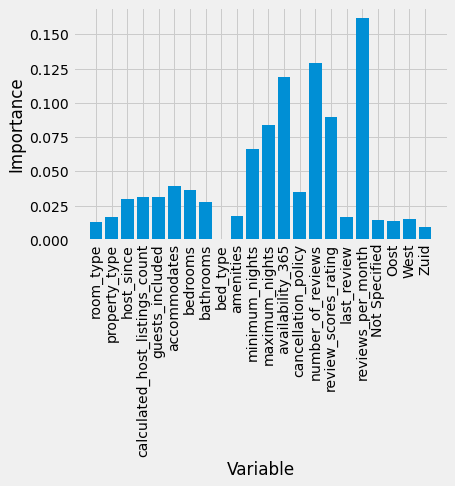

In [152]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list1, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); 

In [153]:
# Find number of features for cumulative importance of 95%
# Add 1 because Python is zero-indexed
importance_sorted = sorted(importances, reverse=True)
cumulative_importances = np.cumsum(importance_sorted)

print('Number of features for 95% importance:', np.where(cumulative_importances >= 0.95)[0][0] + 1)

Number of features for 95% importance: 18


### Graphs illustrating trees

In [0]:
from sklearn.tree import export_graphviz
import pydot

In [0]:
# # Pull out one tree from the forest
# tree = regressor.estimators_[5]
# # Export the image to a dot file
# export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list1, rounded = True, precision = 1)
# # Use dot file to create a graph
# (graph, ) = pydot.graph_from_dot_file('tree.dot')
# # Write graph to a png file
# graph.write_png('tree.png')

# # importing matplotlib modules 
# import matplotlib.image as mpimg 
# import matplotlib.pyplot as plt 
  
# # Read Images 
# img = mpimg.imread('tree.png') 
  
# # Output Images 
# plt.imshow(img) 

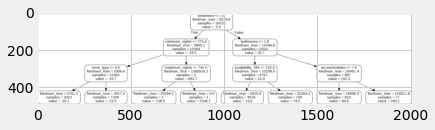

In [156]:
# Limit depth of tree to 3 levels
rf_small = GradientBoostingRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(X_train1, y_train1)
# Extract the small tree
tree_small = rf_small.estimators_[5]
tree_small = tree_small[0]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list1, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

# importing matplotlib modules 
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt 
  
# Read Images 
img = mpimg.imread('small_tree.png') 
  
# Output Images 
plt.imshow(img) 

# Comparing

In [157]:
type(y_test1)

pandas.core.series.Series

In [158]:
type(y_pred_best_random_forrest)

numpy.ndarray

In [0]:
y_test1 = pd.DataFrame(y_test1)
y_test1 = y_test1.reset_index().drop(['index'],axis=1)

y_pred_best_OLS = pd.DataFrame(y_pred_best_OLS)
y_pred_best_OLS = y_pred_best_OLS.reset_index().drop(['index'],axis=1)
y_pred_best_OLS.columns = ['price']


y_pred_best_random_forrest = pd.DataFrame(y_pred_best_random_forrest)
y_pred_best_random_forrest = y_pred_best_random_forrest.reset_index().drop(['index'],axis=1)
y_pred_best_random_forrest.columns = ['price']


y_pred_best_gb = pd.DataFrame(y_pred_best_gb)
y_pred_best_gb = y_pred_best_gb.reset_index().drop(['index'],axis=1)
y_pred_best_gb.columns = ['price']


# , axis=1, sort=False
all_values = pd.concat([y_test1, y_pred_best_OLS, y_pred_best_random_forrest, y_pred_best_gb], axis=1)
all_values.columns = ['y_test1','y_pred_best_OLS','y_pred_best_random_forrest','y_pred_best_gb']

In [160]:
# Any values below 0
print((all_values<0).values.any())

print(all_values.min())

True
y_test1                       14.000000
y_pred_best_OLS               -5.095664
y_pred_best_random_forrest    51.095290
y_pred_best_gb                22.010580
dtype: float64


In [161]:
all_values.describe()

,y_test1,y_pred_best_OLS,y_pred_best_random_forrest,y_pred_best_gb
count,4005.000000,4005.000000,4005.000000,4005.000000
mean,149.010487,150.111232,149.553444,145.917417
std,93.069941,59.984385,61.274655,64.965313
min,14.000000,-5.095664,51.095290,22.010580
25%,97.000000,109.894693,112.942071,107.275449
50%,125.000000,136.678928,132.042677,129.852343
75%,175.000000,187.340648,173.852962,169.828146
max,1500.000000,671.656391,717.315545,764.848111


https://towardsdatascience.com/metrics-and-python-850b60710e0c

In [0]:
eval_comparison_table = pd.DataFrame(np.zeros((7,3)), columns=['OLS','RF','GB'], index=['MAE','MSE','RMSE','MAPE','RMSLE','R2','R'])

In [163]:
# OLS

from sklearn.metrics import mean_absolute_error
print ('Sk MAE: ' + str(mean_absolute_error(y_test1, y_pred_best_OLS)) )
eval_comparison_table.loc['MAE','OLS'] = round(mean_absolute_error(y_test1, y_pred_best_OLS),3)

def MAE(predict,target):
    return (abs(predict-target)).mean()

from sklearn.metrics import mean_squared_error
print ('Sk MSE: ' + str(mean_squared_error(y_test1,y_pred_best_OLS)) )
eval_comparison_table.loc['MSE','OLS'] = round(mean_squared_error(y_test1,y_pred_best_OLS),3)


def RMSE(predict, target):
    return np.sqrt(((predict - target) ** 2).mean())
print ('My RMSE: ' + str(RMSE(y_pred_best_OLS,y_test1)) )
eval_comparison_table.loc['RMSE','OLS'] = round(RMSE(y_pred_best_OLS,y_test1),3)[0]

def MAPE(predict,target):
    return ( abs((target - predict) / target).mean()) * 100
print ('My MAPE: ' + str(MAPE(y_pred_best_OLS,y_test1)) )
eval_comparison_table.loc['MAPE','OLS'] = round(MAPE(y_pred_best_OLS,y_test1),3)[0]

import math
def RMSLE(predict, target):
    total = 0 
    for k in range(len(predict)):
        LPred= np.log1p(predict[k]+1)
        LTarg = np.log1p(target[k] + 1)
        if not (math.isnan(LPred)) and  not (math.isnan(LTarg)): 
            total = total + ((LPred-LTarg) **2)
        
    total = total / len(predict)        
    return np.sqrt(total)
print ('My RMSLE: ' + str(RMSLE(y_pred_best_OLS.to_numpy(),y_test1.to_numpy())) )
eval_comparison_table.loc['RMSLE','OLS'] = round(RMSLE(y_pred_best_OLS.to_numpy(),y_test1.to_numpy())[0],3)


def R2(predict, target):
    return 1 - (MAE(predict,target) / MAE(target.mean(),target))
def R_SQR(predict, target):
    r2 = R2(predict,target)
    return np.sqrt(r2)
print ('My R2         : ' + str(R2(y_pred_best_OLS,y_test1)) )
print ('My R          : ' + str(R_SQR(y_pred_best_OLS,y_test1)) )
eval_comparison_table.loc['R2','OLS'] = round(R2(y_pred_best_OLS,y_test1)[0],3)
eval_comparison_table.loc['R','OLS'] = round(R_SQR(y_pred_best_OLS,y_test1)[0],3)

Sk MAE: 44.387095683065546
Sk MSE: 5328.057559662884
My RMSE: price    72.993545
dtype: float64
My MAPE: price    32.394163
dtype: float64
My RMSLE: [0.37458402]
My R2         : price    0.255407
dtype: float64
My R          : price    0.505378
dtype: float64


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log1p


In [164]:
# RF y_pred_best_random_forrest

from sklearn.metrics import mean_absolute_error
print ('Sk MAE: ' + str(mean_absolute_error(y_test1, y_pred_best_random_forrest)) )
eval_comparison_table.loc['MAE','RF'] = round(mean_absolute_error(y_test1, y_pred_best_random_forrest),3)

def MAE(predict,target):
    return (abs(predict-target)).mean()

from sklearn.metrics import mean_squared_error
print ('Sk MSE: ' + str(mean_squared_error(y_test1,y_pred_best_random_forrest)) )
eval_comparison_table.loc['MSE','RF'] = round(mean_squared_error(y_test1,y_pred_best_random_forrest),3)


def RMSE(predict, target):
    return np.sqrt(((predict - target) ** 2).mean())
print ('My RMSE: ' + str(RMSE(y_pred_best_random_forrest,y_test1)) )
eval_comparison_table.loc['RMSE','RF'] = round(RMSE(y_pred_best_random_forrest,y_test1),3)[0]

def MAPE(predict,target):
    return ( abs((target - predict) / target).mean()) * 100
print ('My MAPE: ' + str(MAPE(y_pred_best_OLS,y_test1)) )
eval_comparison_table.loc['MAPE','RF'] = round(MAPE(y_pred_best_random_forrest,y_test1),3)[0]

import math
def RMSLE(predict, target):
    total = 0 
    for k in range(len(predict)):
        LPred= np.log1p(predict[k]+1)
        LTarg = np.log1p(target[k] + 1)
        if not (math.isnan(LPred)) and  not (math.isnan(LTarg)): 
            total = total + ((LPred-LTarg) **2)
        
    total = total / len(predict)        
    return np.sqrt(total)
print ('My RMSLE: ' + str(RMSLE(y_pred_best_random_forrest.to_numpy(),y_test1.to_numpy())) )
eval_comparison_table.loc['RMSLE','RF'] = round(RMSLE(y_pred_best_random_forrest.to_numpy(),y_test1.to_numpy())[0],3)


def R2(predict, target):
    return 1 - (MAE(predict,target) / MAE(target.mean(),target))
def R_SQR(predict, target):
    r2 = R2(predict,target)
    return np.sqrt(r2)
print ('My R2         : ' + str(R2(y_pred_best_random_forrest,y_test1)) )
print ('My R          : ' + str(R_SQR(y_pred_best_random_forrest,y_test1)) )
eval_comparison_table.loc['R2','RF'] = round(R2(y_pred_best_random_forrest,y_test1)[0],3)
eval_comparison_table.loc['R','RF'] = round(R_SQR(y_pred_best_random_forrest,y_test1)[0],3)

Sk MAE: 40.41282836246371
Sk MSE: 4738.9836928526465
My RMSE: price    68.840277
dtype: float64
My MAPE: price    32.394163
dtype: float64
My RMSLE: [0.33935909]
My R2         : price    0.322076
dtype: float64
My R          : price    0.567517
dtype: float64


In [165]:
# GB y_pred_best_gb

from sklearn.metrics import mean_absolute_error
print ('Sk MAE: ' + str(mean_absolute_error(y_test1, y_pred_best_gb)) )
eval_comparison_table.loc['MAE','GB'] = round(mean_absolute_error(y_test1, y_pred_best_gb),3)

def MAE(predict,target):
    return (abs(predict-target)).mean()

from sklearn.metrics import mean_squared_error
print ('Sk MSE: ' + str(mean_squared_error(y_test1,y_pred_best_gb)) )
eval_comparison_table.loc['MSE','GB'] = round(mean_squared_error(y_test1,y_pred_best_gb),3)


def RMSE(predict, target):
    return np.sqrt(((predict - target) ** 2).mean())
print ('My RMSE: ' + str(RMSE(y_pred_best_gb,y_test1)) )
eval_comparison_table.loc['RMSE','GB'] = round(RMSE(y_pred_best_gb,y_test1),3)[0]

def MAPE(predict,target):
    return ( abs((target - predict) / target).mean()) * 100
print ('My MAPE: ' + str(MAPE(y_pred_best_gb,y_test1)) )
eval_comparison_table.loc['MAPE','GB'] = round(MAPE(y_pred_best_gb,y_test1),3)[0]

import math
def RMSLE(predict, target):
    total = 0 
    for k in range(len(predict)):
        LPred= np.log1p(predict[k]+1)
        LTarg = np.log1p(target[k] + 1)
        if not (math.isnan(LPred)) and  not (math.isnan(LTarg)): 
            total = total + ((LPred-LTarg) **2)
        
    total = total / len(predict)        
    return np.sqrt(total)
print ('My RMSLE: ' + str(RMSLE(y_pred_best_gb.to_numpy(),y_test1.to_numpy())) )
eval_comparison_table.loc['RMSLE','GB'] = round(RMSLE(y_pred_best_gb.to_numpy(),y_test1.to_numpy())[0],3)


def R2(predict, target):
    return 1 - (MAE(predict,target) / MAE(target.mean(),target))
def R_SQR(predict, target):
    r2 = R2(predict,target)
    return np.sqrt(r2)
print ('My R2         : ' + str(R2(y_pred_best_gb,y_test1)) )
print ('My R          : ' + str(R_SQR(y_pred_best_gb,y_test1)) )
eval_comparison_table.loc['R2','GB'] = round(R2(y_pred_best_gb,y_test1)[0],3)
eval_comparison_table.loc['R','GB'] = round(R_SQR(y_pred_best_gb,y_test1)[0],3)

Sk MAE: 41.311963532494495
Sk MSE: 4879.867841118451
My RMSE: price    69.856051
dtype: float64
My MAPE: price    28.672754
dtype: float64
My RMSLE: [0.34700709]
My R2         : price    0.306993
dtype: float64
My R          : price    0.554069
dtype: float64


In [166]:
eval_comparison_table

,OLS,RF,GB
MAE,44.387,40.413,41.312
MSE,5328.058,4738.984,4879.868
RMSE,72.994,68.840,69.856
MAPE,32.394,29.196,28.673
RMSLE,0.375,0.339,0.347
R2,0.255,0.322,0.307
R,0.505,0.568,0.554


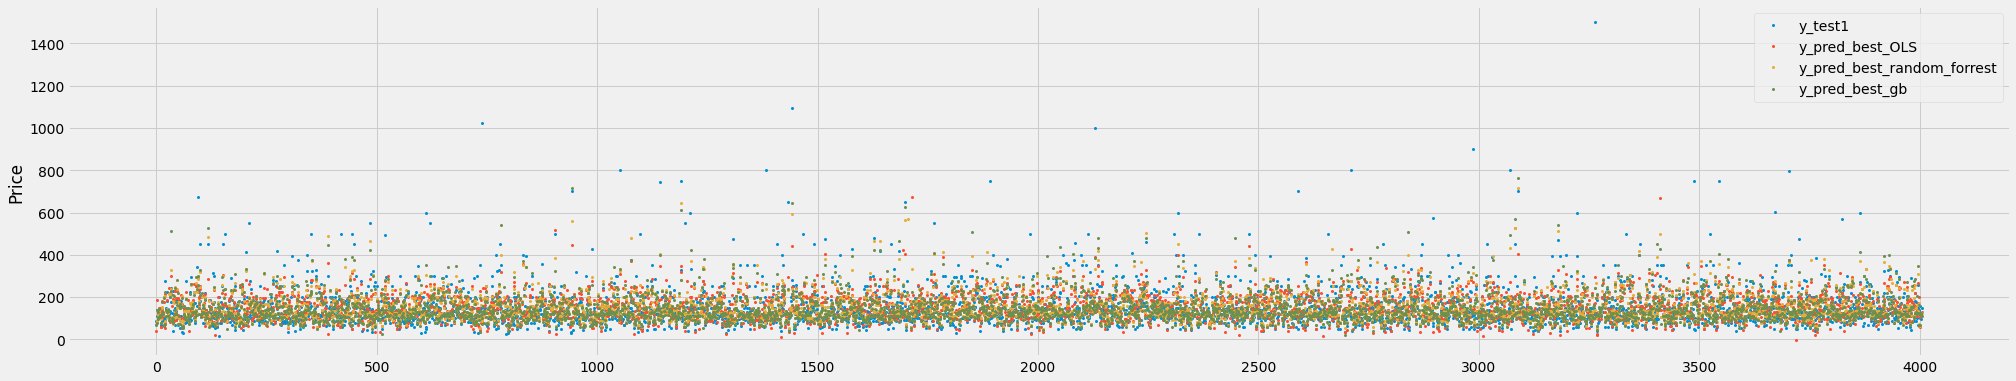

In [167]:
from matplotlib.pyplot import figure
figure(figsize=(31, 6))
y = all_values
x = list(range(y.shape[0]))
# plt.xlabel('Method used')
plt.ylabel('Price')
colors = list()
plt.plot(x, y, linewidth=0, marker="o",markersize=2, linestyle='solid')
plt.legend(all_values.columns.values)
# plt.ylim(-10,2000)
plt.show()

In [168]:
valuesy = y['y_test1']
valuesy.idxmax()


3264

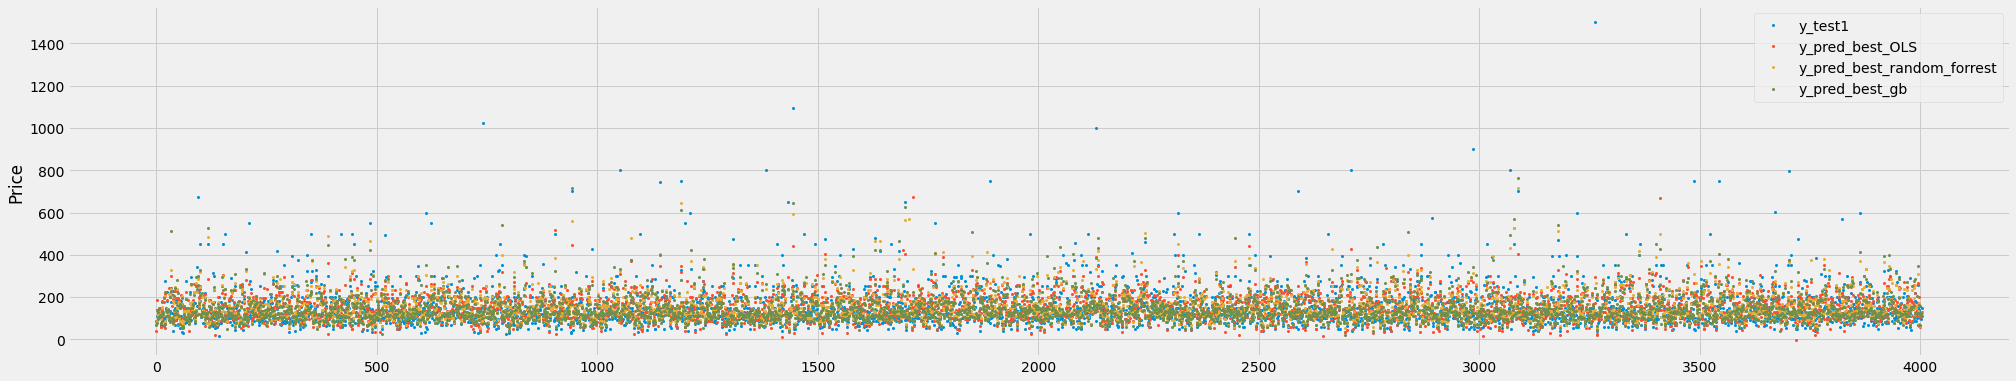

In [169]:
from matplotlib.pyplot import figure
figure(figsize=(31, 6))
y = all_values.drop(2154)
x = list(range(y.shape[0]))
# plt.xlabel('Method used')
plt.ylabel('Price')
colors = list()
plt.plot(x, y, linewidth=0, marker="o",markersize=2, linestyle='solid')
plt.legend(all_values.columns.values)
# plt.ylim(-10,2000)
plt.show()

In [170]:
valuesy

0        85
1       109
2       140
3       119
4       129
       ... 
4000    100
4001    160
4002    119
4003     96
4004    149
Name: y_test1, Length: 4005, dtype: int64

In [171]:
value0 = all_values.shape[0]
value1 = all_values.shape[1]
print(value0)
print(value1)
value1 = all_values.shape[0]
value0 = all_values.shape[1]
diff_all_values = pd.DataFrame(np.zeros((value1,value0)))
for j in list(range(value0)):
  for i in list(range(value1)):
    diff_all_values.iloc[i,j] = all_values.iloc[i,j]-all_values.iloc[i,0]
diff_all_values = diff_all_values.rename(columns={0:'y_test1',1:'y_pred_best_OLS',
                                                  2:'y_pred_best_random_forrest',
                                                  3:'y_pred_best_gb'})
# diff_all_values

4005
4


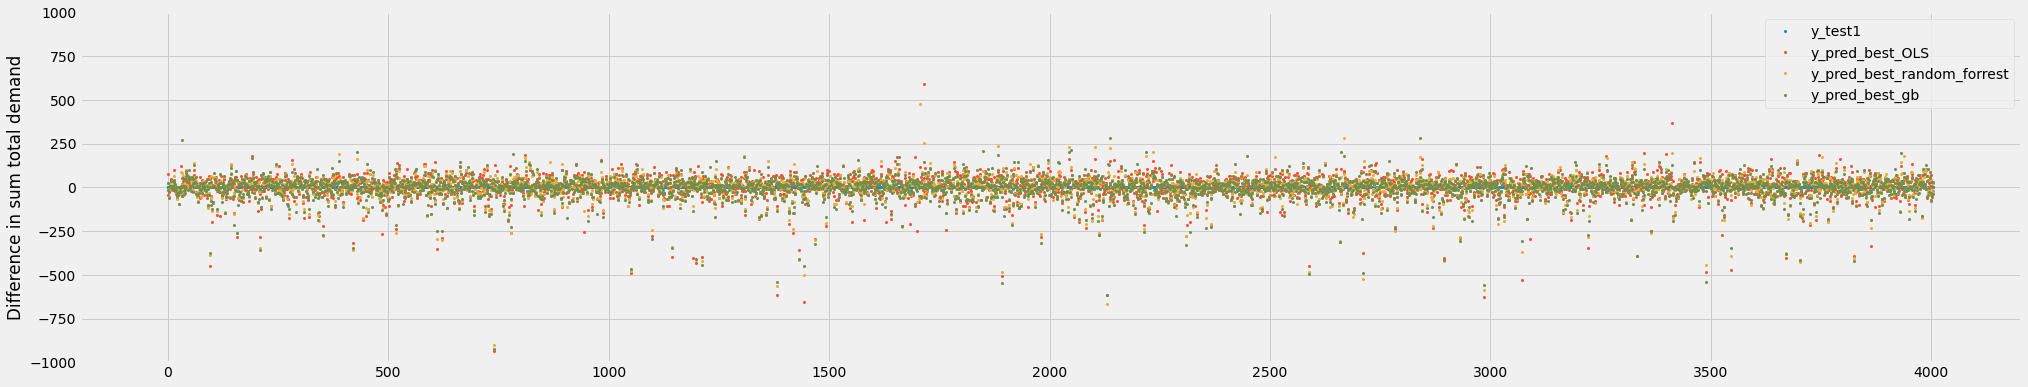

In [172]:
from matplotlib.pyplot import figure
from matplotlib.pyplot import hlines
figure(figsize=(31, 6))
y = diff_all_values
x = list(range(y.shape[0]))
plt.ylabel('Difference in sum total demand')
plt.plot(x, y, linewidth=0.3, marker="o", markersize=2, linestyle='None')
hlines(1,0, 744, linewidth=0.5)
plt.legend(diff_all_values.columns.values)
plt.ylim(-1000,1000)
plt.show()